___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width="150" height="100" />


# SEGUNDO EXAMEN PARCIAL
# MODELO NO LINEAL PARA PRONÓSTICOS

## Examen Tema 2
## Nombre: Melanie Michel Rodríguez

## Fecha: 25 de marzo del 2025

## Por: Oscar David Jaramillo Z.

# **Examen de Series de Tiempo con Redes Neuronales**

## **Instrucciones Generales**

En este examen trabajarás con dos conjuntos de datos diferentes: **univariado** y **multivariado**. Los datos univariados se encuentran en la carpeta `univariate`, y los datos multivariados en la carpeta `multivariate`.

Deberás implementar los modelos de redes neuronales **MLP**, **CNN**, **LSTM** y **CNN-LSTM** para realizar predicciones en ambos conjuntos de datos.

Deberás justificar tus decisiones y documentar adecuadamente tu código y procedimientos.



---

## **Conjunto de Datos**

### **2. Datos Multivariados**

- **Archivo:** `Daily Demand Forecasting Orders`.
- **Descripción:**
  - Contiene 60 filas (días) y 13 columnas (atributos).
  - Objetivo: Predecir el total de pedidos diarios (`Target`) utilizando los demás atributos como variables predictoras.
- **Atributos:**
  - Los atributos en este conjunto de datos son los siguientes:

        Week of the month: La semana del mes (1 a 5).
        Day of the week (Monday to Friday): El día de la semana (2 a 6).
        Non-urgent order: El número de pedidos no urgentes.
        Urgent order: El número de pedidos urgentes.
        Order type A: El número de pedidos de tipo A.
        Order type B: El número de pedidos de tipo B.
        Order type C: El número de pedidos de tipo C.
        Fiscal sector orders: El número de pedidos del sector fiscal.
        Orders from the traffic controller sector: El número de pedidos del sector controlador de tráfico.
        Banking orders (1): El número de pedidos bancarios (1).
        Banking orders (2): El número de pedidos bancarios (2).
        Banking orders (3): El número de pedidos bancarios (3).
        Target (Total orders): El total de pedidos (objetivo).

---

## **Tareas y Requisitos**

Para ambos conjuntos de datos (univariado y multivariado), realiza las siguientes tareas para cada red neuronal (MLP, CNN, LSTM y CNN-LSTM):

### **1. Análisis de Datos (20%)**

- **Carga los datos** y realiza una visualización clara de las series asignadas o los atributos del conjunto de datos.
- Realiza las transformaciones o preprocesamiento que consideres necesarios.
- Justifica tus decisiones de preprocesamiento y explica cualquier análisis relevante que realices.

### **2. División de Datos (10%)**

- Divide los datos en conjuntos de entrenamiento, validación y prueba.
- **Multivariado:**
  - Divide las filas en un 70%-15%-15% (entrenamiento, validación, prueba).

### **3. Creación de Modelos (30%)**

- **Diseña las redes neuronales** utilizando MLP, CNN, LSTM y CNN-LSTM:
  - Implementa al menos **tres arquitecturas diferentes** para cada modelo.
  - Selecciona la estructura que arroje mejores resultados.
- Justifica la elección de las capas ocultas, funciones de activación, optimizadores y otras configuraciones.
- Discute los resultados obtenidos y menciona posibles formas de mejorar el rendimiento.

### **4. Evaluación del Modelo (20%)**

- Evalúa los modelos en el conjunto de prueba.
- Compara los pronósticos con los valores reales:
  - Si realizaste alguna transformación en los datos (como normalización), revierte las transformaciones antes de la comparación.
- Mide la precisión del modelo utilizando métricas adecuadas como:
  - **RMSE, MAE, MAPE, o R².**

### **5. Optimización con Optuna (15%)**

- Implementa **Optuna** para ajustar los hiperparámetros del modelo:
  - Ajusta al menos los siguientes hiperparámetros:
    - Número de capas, número de unidades, tasa de aprendizaje, tipo de optimizador y funciones de activación.
  - Evalúa el modelo optimizado en el conjunto de prueba.
- Documenta los cambios en el rendimiento antes y después de la optimización.

---

## **Formato y Presentación (5%)**

1. **Estructura del Trabajo:**
   - Introducción a los datos y al modelo.
   - Explicación del preprocesamiento realizado.
   - Descripción y justificación de las arquitecturas probadas.
   - Análisis de resultados antes y después de la optimización.
2. **Código:**
   - Bien comentado y estructurado.
   - Justifica cada paso del código con explicaciones claras.
3. **Gráficos:**
   - Incluye gráficos de las series de tiempo, visualización de errores y desempeño del modelo.
4. **Conclusión:**
   - Resume tus hallazgos, dificultades encontradas y posibles mejoras.

---

**¡Éxito con tu examen!**


## Implementación de modelos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [12]:
class MultivariateForecaster:
    def __init__(self, data_path, target_col='Target (Total orders)'):
        """
        Inicializa el forecast multivariado con datos de un archivo CSV.

        Parameters:
        data_path : str
            Ruta al archivo CSV con los datos
        target_col : str
            Nombre de la columna objetivo
        """
        # Cargar datos
        self.data = pd.read_csv(data_path, delimiter=';')
        self.target_col = target_col

        # Preprocesamiento inicial
        self.preprocess_data()

        # Almacenamiento de modelos y resultados
        self.models = {}
        self.scalers = {}
        self.results = {}
        self.best_models = {}

    def preprocess_data(self):
        """
        Preprocesamiento básico de los datos multivariados.
        """
        # Verificar y limpiar datos
        print("Datos originales:")
        print(self.data.head())
        print("\nInformación del dataset:")
        print(self.data.info())

        # Eliminar filas con valores faltantes si las hay
        self.data = self.data.dropna()

        # Separar características y target
        self.features = self.data.drop(columns=[self.target_col])
        self.target = self.data[self.target_col]

        # Convertir a numpy arrays
        self.X = self.features.values
        self.y = self.target.values.reshape(-1, 1)

    def visualize_data(self):
        """
        Visualización de las series multivariadas.
        """
        plt.figure(figsize=(15, 10))

        # Visualizar cada característica
        for i, col in enumerate(self.features.columns):
            plt.subplot(len(self.features.columns)//3 + 1, 3, i+1)
            plt.plot(self.features[col], label=col)
            plt.title(col)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Visualizar target
        plt.figure(figsize=(12, 6))
        plt.plot(self.target, label=f'Target ({self.target_col})')
        plt.title("Serie Temporal del Target")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.show()

    def create_sequences(self, data, target, n_steps):
        """
        Crea secuencias para el modelo.

        Parameters:
        data : array
            Datos multivariados (features)
        target : array
            Variable objetivo
        n_steps : int
            Número de pasos temporales en cada secuencia

        Returns:
        tuple
            (X, y) arrays para entrenamiento
        """
        X, y = [], []
        for i in range(len(data) - n_steps):
            X.append(data[i:i+n_steps])
            y.append(target[i+n_steps])
        return np.array(X), np.array(y)

    def prepare_data(self, n_steps=7, test_size=0.15):
        """
        Prepara los datos para modelado.

        Parameters:
        n_steps : int
            Número de pasos temporales a usar como ventana
        test_size : float
            Porcentaje de datos a usar como prueba (será dividido en val y test)

        Returns:
        tuple
            (X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y)
        """
        # Escalar características
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler_X.fit_transform(self.X)

        # Escalar target
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler_y.fit_transform(self.y)

        # Crear secuencias
        X_seq, y_seq = self.create_sequences(X_scaled, y_scaled, n_steps)

        # División 70-15-15
        # Primero separar train (70%) y temp (30%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_seq, y_seq, test_size=0.3, random_state=42, shuffle=False
        )

        # Luego dividir temp en val (15%) y test (15%)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
        )

        print(f"\nDivisión de datos:")
        print(f"Train: {X_train.shape}, {y_train.shape}")
        print(f"Val: {X_val.shape}, {y_val.shape}")
        print(f"Test: {X_test.shape}, {y_test.shape}")

        # Guardar scalers para uso posterior
        self.scalers = {'X': scaler_X, 'y': scaler_y}

        return X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y

    # ========================================================================
    # ARQUITECTURAS DE MODELOS (3 por tipo)
    # ========================================================================

    def build_mlp_model(self, input_shape, version=1):
        """
        Construye modelo MLP con 3 arquitecturas diferentes.

        Parameters:
        input_shape : tuple
            Forma de los datos de entrada
        version : int
            Versión de arquitectura (1, 2 o 3)

        Returns:
        model : keras.Model
            Modelo compilado
        """
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Flatten())

        if version == 1:
            # Arquitectura simple (como ejemplo básico)
            model.add(Dense(100, activation='relu'))
            model.add(Dense(50, activation='relu'))
            model.add(Dense(1))
            optimizer = RMSprop(learning_rate=0.001)

        elif version == 2:
            # Arquitectura más profunda con regularización
            model.add(Dense(200, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(Dropout(0.3))
            model.add(Dense(100, activation='relu'))
            model.add(Dense(50, activation='relu'))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.0005)

        elif version == 3:
            # Arquitectura con capas más estrechas
            model.add(Dense(150, activation='tanh'))
            model.add(Dropout(0.2))
            model.add(Dense(75, activation='tanh'))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.0001)

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def build_cnn_model(self, input_shape, version=1):
        """
        Modelo CNN con 3 arquitecturas diferentes.

        Parameters:
        input_shape : tuple
            Forma de los datos de entrada
        version : int
            Versión de arquitectura (1, 2 o 3)

        Returns:
        model : keras.Model
            Modelo compilado
        """
        model = Sequential()
        model.add(Input(shape=input_shape))

        if version == 1:
            # Arquitectura básica (como ejemplo de clase)
            model.add(Conv1D(64, 2, activation='relu'))
            model.add(MaxPooling1D())
            model.add(Flatten())
            model.add(Dense(50, activation='relu'))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.001)

        elif version == 2:
            # Arquitectura con múltiples capas convolucionales
            model.add(Conv1D(128, 3, activation='relu', padding='same'))
            model.add(MaxPooling1D(2))
            model.add(Conv1D(64, 3, activation='relu', padding='same'))
            model.add(MaxPooling1D(2))
            model.add(Flatten())
            model.add(Dense(100, activation='relu'))
            model.add(Dropout(0.3))
            model.add(Dense(50, activation='relu'))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.0005)

        elif version == 3:
            # Arquitectura con convoluciones dilatadas
            model.add(Conv1D(64, 3, activation='relu', dilation_rate=2, padding='causal'))
            model.add(MaxPooling1D(2))
            model.add(Conv1D(128, 3, activation='relu', padding='same'))
            model.add(MaxPooling1D(2))
            model.add(Flatten())
            model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(Dropout(0.4))
            model.add(Dense(1))
            optimizer = RMSprop(learning_rate=0.0001)

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def build_lstm_model(self, input_shape, version=1):
        """
        Modelo LSTM con 3 arquitecturas diferentes.

        Parameters:
        input_shape : tuple
            Forma de los datos de entrada
        version : int
            Versión de arquitectura (1, 2 o 3)

        Returns:
        model : keras.Model
            Modelo compilado
        """
        model = Sequential()
        model.add(Input(shape=input_shape))

        if version == 1:
            # Arquitectura simple (como ejemplo de clase)
            model.add(LSTM(50, activation='relu'))
            model.add(Dense(1))
            optimizer = RMSprop(learning_rate=0.001)

        elif version == 2:
            # Arquitectura apilada con bidireccional
            model.add(Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))
            model.add(Dropout(0.3))
            model.add(Bidirectional(LSTM(50, activation='tanh')))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.0005)

        elif version == 3:
            # Arquitectura con capas densas intermedias
            model.add(LSTM(64, activation='tanh', return_sequences=True))
            model.add(LSTM(32, activation='tanh'))
            model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.0001)

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    def build_cnn_lstm_model(self, input_shape, version=1):
        """
        Construye modelo CNN-LSTM con 3 arquitecturas diferentes.

        Parameters:
        input_shape : tuple
            Forma de los datos de entrada
        version : int
            Versión de arquitectura (1, 2 o 3)

        Returns:
        model : keras.Model
            Modelo compilado
        """
        model = Sequential()
        model.add(Input(shape=input_shape))

        if version == 1:
            # Arquitectura básica CNN-LSTM
            model.add(Conv1D(64, 3, activation='relu'))
            model.add(MaxPooling1D(2))
            model.add(LSTM(50, activation='tanh'))
            model.add(Dense(1))
            optimizer = RMSprop(learning_rate=0.001)

        elif version == 2:
            # Arquitectura con múltiples capas CNN y LSTM
            model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Dropout(0.2))
            model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(64, return_sequences=False)))
            model.add(Dropout(0.2))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=0.001)

        elif version == 3:
            # Arquitectura con TimeDistributed

            model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=2))
            model.add(LSTM(50, activation='tanh'))
            model.add(Dense(1))
            optimizer = RMSprop(learning_rate=0.001)

        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model

    # ========================================================================
    # ENTRENAMIENTO Y EVALUACIÓN
    # ========================================================================

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, verbose=1):
        """
        Entrena un modelo y devuelve su historial.
        """
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
        ]

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        return history

    def evaluate_model(self, model, X_test, y_test, model_name, version):
        """
        Evalúa un modelo en los datos de prueba.
        """
        # Predecir
        y_pred = model.predict(X_test)

        # Invertir escalado
        y_test_inv = self.scalers['y'].inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = self.scalers['y'].inverse_transform(y_pred.reshape(-1, 1))

        # Calcular métricas
        mse = mean_squared_error(y_test_inv, y_pred_inv)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
        r2 = r2_score(y_test_inv, y_pred_inv)

        # Mostrar resultados
        print(f"\nEvaluación - Modelo {model_name} V{version}:")
        print("="*60)
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.4f}%")
        print(f"R²: {r2:.4f}")

        # Graficar
        plt.figure(figsize=(14, 6))
        plt.plot(y_test_inv, label='Valores Reales', color='blue', alpha=0.7)
        plt.plot(y_pred_inv, label='Predicciones', color='red', alpha=0.7, linestyle='--')
        plt.title(f"Predicciones vs Valores Reales\nModelo {model_name} V{version}", pad=20)
        plt.xlabel("Tiempo")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'y_test': y_test_inv,
            'y_pred': y_pred_inv
        }

    def train_and_evaluate_all_models(self, n_steps=7, epochs=100, batch_size=32):
        """
        Entrena y evalúa todos los modelos con diferentes arquitecturas.
        """
        print("\n" + "="*60)
        print("PREPARACIÓN DE DATOS")
        print("="*60)
        X_train, y_train, X_val, y_val, X_test, y_test, _, _ = self.prepare_data(n_steps=n_steps)

        # Configuración de modelos a probar
        models_config = {
            'MLP': {'builder': self.build_mlp_model, 'versions': [1, 2, 3]},
            'CNN': {'builder': self.build_cnn_model, 'versions': [1, 2, 3]},
            'LSTM': {'builder': self.build_lstm_model, 'versions': [1, 2, 3]},
            'CNN-LSTM': {'builder': self.build_cnn_lstm_model, 'versions': [1, 2, 3]}
        }

        results = {}

        for model_name, config in models_config.items():
            print("\n" + "="*60)
            print(f"ENTRENANDO MODELOS {model_name}")
            print("="*60)

            model_results = {}
            best_score = float('inf')
            best_version = None

            for version in config['versions']:
                print(f"\n{model_name} - Versión {version}")

                # Construir modelo
                model = config['builder'](X_train.shape[1:], version=version)

                # Entrenar modelo
                history = self.train_model(
                    model, X_train, y_train, X_val, y_val,
                    epochs=epochs, batch_size=batch_size, verbose=1
                )

                # Evaluar modelo
                eval_results = self.evaluate_model(
                    model, X_test, y_test, model_name, version
                )

                # Guardar resultados
                model_results[version] = {
                    'model': model,
                    'history': history,
                    'metrics': eval_results
                }

                # Actualizar mejor modelo de este tipo
                if eval_results['rmse'] < best_score:
                    best_score = eval_results['rmse']
                    best_version = version

            # Guardar el mejor modelo de este tipo
            results[model_name] = {
                'all_versions': model_results,
                'best_version': best_version,
                'best_metrics': model_results[best_version]['metrics']
            }

        # Guardar todos los resultados
        self.results = results

        # Identificar el mejor modelo global
        best_model_type = None
        best_rmse = float('inf')

        for model_type, data in results.items():
            if data['best_metrics']['rmse'] < best_rmse:
                best_rmse = data['best_metrics']['rmse']
                best_model_type = model_type

        print("\n" + "="*60)
        print(f"MEJOR MODELO GLOBAL: {best_model_type} V{results[best_model_type]['best_version']}")
        print(f"RMSE: {best_rmse:.4f}")
        print("="*60)

        # Guardar el mejor modelo global
        self.best_model = {
            'type': best_model_type,
            'version': results[best_model_type]['best_version'],
            'model': results[best_model_type]['all_versions'][results[best_model_type]['best_version']]['model'],
            'metrics': results[best_model_type]['best_metrics']
        }

        return results

    def compare_models(self):
        """
        Compara el rendimiento de todos los modelos.
        """
        if not self.results:
            print("No hay resultados para comparar. Ejecuta train_and_evaluate_all_models() primero.")
            return

        # Preparar datos para comparación
        comparison_data = []

        for model_type, model_data in self.results.items():
            for version, version_data in model_data['all_versions'].items():
                metrics = version_data['metrics']

                comparison_data.append({
                    'Modelo': f"{model_type}-V{version}",
                    'RMSE': metrics['rmse'],
                    'MAE': metrics['mae'],
                    'MAPE': f"{metrics['mape']:.2f}%",
                    'R2': f"{metrics['r2']:.4f}"
                })

        # Crear DataFrame de comparación
        comparison_df = pd.DataFrame(comparison_data)

        # Mostrar tabla de comparación
        print("\nComparación de Modelos:")
        print("="*80)
        print(comparison_df.to_string(index=False))

        # Gráfico de comparación de RMSE
        plt.figure(figsize=(12, 6))
        comparison_df.set_index('Modelo')['RMSE'].plot(kind='bar', color='skyblue')
        plt.title('Comparación de RMSE entre Modelos')
        plt.ylabel('RMSE')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return comparison_df

    def forecast_future(self, n_steps=7, n_forecast=7):
        """
        Realiza pronósticos futuros usando el mejor modelo.
        """
        if not hasattr(self, 'best_model'):
            print("No hay modelo entrenado. Ejecuta train_and_evaluate_all_models() primero.")
            return

        # Obtener los datos más recientes
        X_scaled = self.scalers['X'].transform(self.X)
        y_scaled = self.scalers['y'].transform(self.y)

        # Crear secuencia más reciente
        last_sequence = X_scaled[-n_steps:]
        last_sequence = last_sequence.reshape((1, n_steps, self.X.shape[1]))

        # Realizar pronósticos
        forecasts = []
        current_sequence = last_sequence.copy()

        for _ in range(n_forecast):
            # Predecir el siguiente paso
            next_pred = self.best_model['model'].predict(current_sequence, verbose=0)
            forecasts.append(next_pred[0, 0])

            # Actualizar la secuencia
            new_sequence = np.append(current_sequence[0, 1:, :], next_pred.reshape(1, 1), axis=0)
            current_sequence = new_sequence.reshape((1, n_steps, self.X.shape[1]))

        # Invertir escalado
        forecasts_inv = self.scalers['y'].inverse_transform(np.array(forecasts).reshape(-1, 1))

        # Crear fechas futuras (asumiendo datos diarios)
        last_date = pd.to_datetime(self.data.index[-1]) if hasattr(self.data.index, 'dtype') else len(self.data)
        future_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='D')[1:]

        # Graficar
        plt.figure(figsize=(12, 6))
        plt.plot(self.target.values[-50:], label='Datos históricos')
        plt.plot(range(len(self.target)-1, len(self.target)+n_forecast),
                np.concatenate([[self.target.values[-1]], forecasts_inv.flatten()]),
                label='Pronóstico', linestyle='--', marker='o')
        plt.title(f"Pronóstico de {n_forecast} pasos futuros")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.show()

        return forecasts_inv

Datos originales:
   Week of the month (first week, second, third, fourth or fifth week  \
0                                                  1                    
1                                                  1                    
2                                                  1                    
3                                                  2                    
4                                                  2                    

   Day of the week (Monday to Friday)  Non-urgent order  Urgent order  \
0                                   4           316.307       223.270   
1                                   5           128.633        96.042   
2                                   6            43.651        84.375   
3                                   2           171.297       127.667   
4                                   3            90.532       113.526   

   Order type A  Order type B  Order type C  Fiscal sector orders  \
0        61.543       175.586      

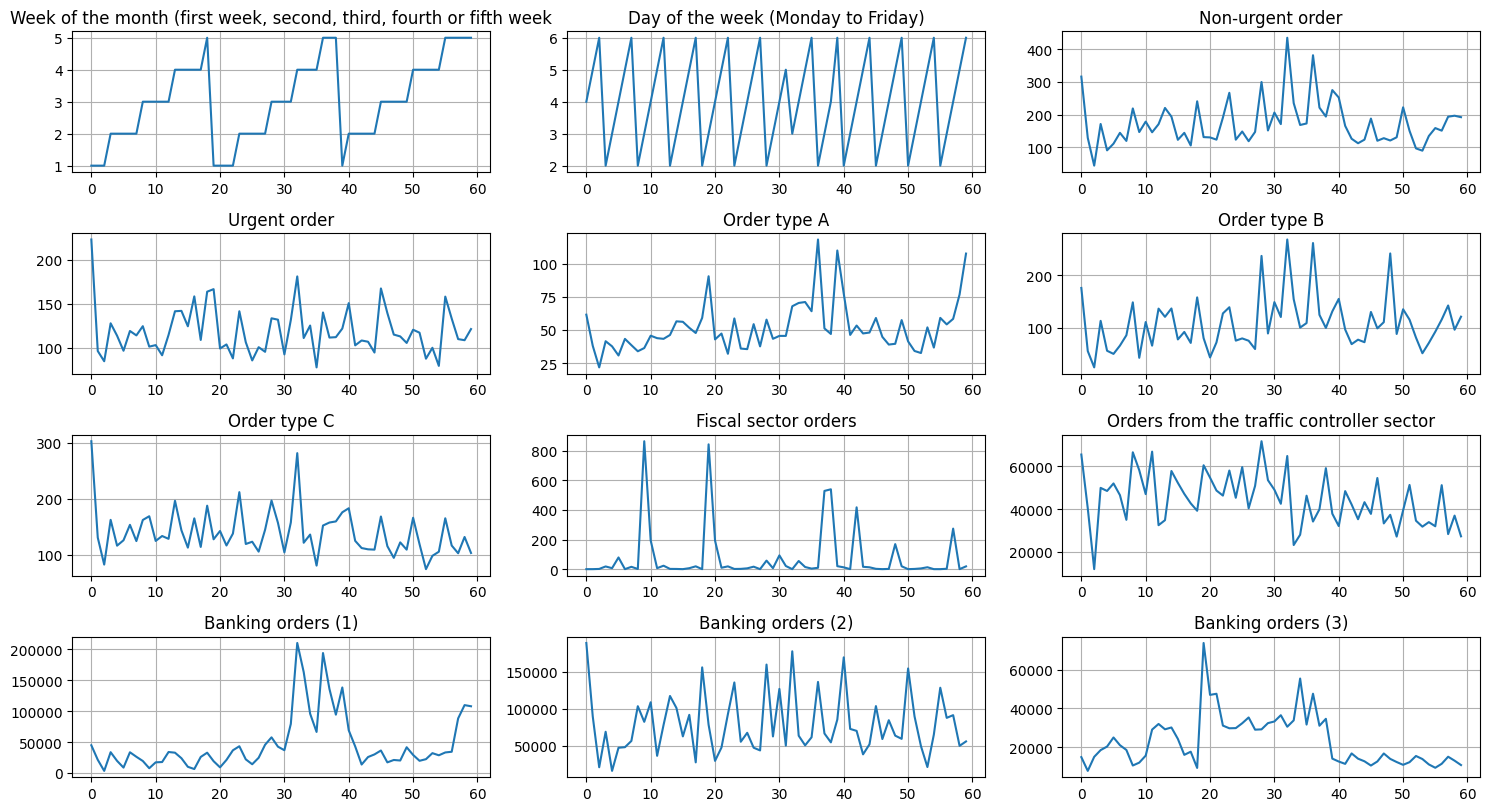

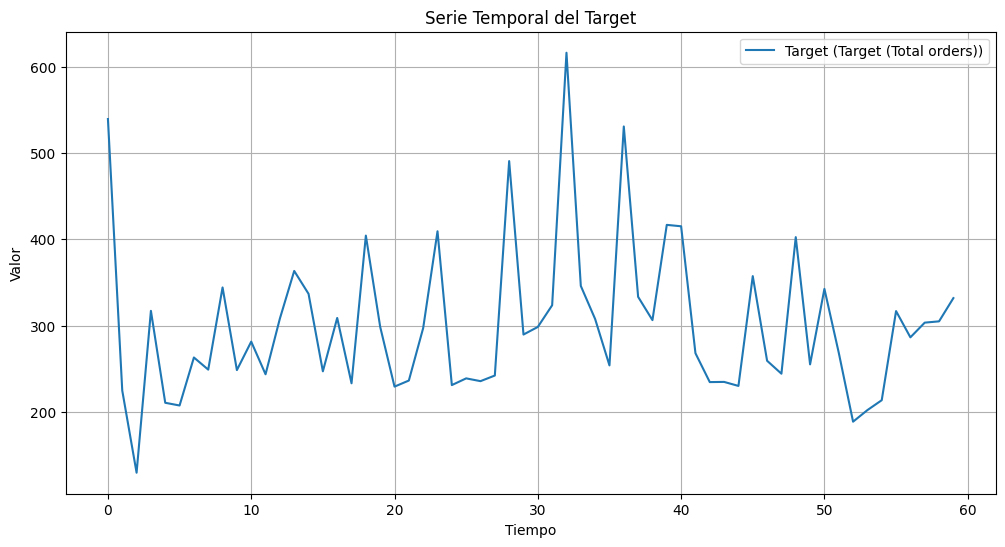


PREPARACIÓN DE DATOS

División de datos:
Train: (37, 7, 12), (37, 1)
Val: (8, 7, 12), (8, 1)
Test: (8, 7, 12), (8, 1)

ENTRENANDO MODELOS MLP

MLP - Versión 1
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - loss: 0.1487 - mae: 0.3273 - val_loss: 0.0396 - val_mae: 0.1675 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0562 - mae: 0.1883 - val_loss: 0.0348 - val_mae: 0.1573 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0496 - mae: 0.1725 - val_loss: 0.0315 - val_mae: 0.1437 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0370 - mae: 0.1469 - val_loss: 0.0354 - val_mae: 0.1545 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0533 - mae: 0.1735 - val_loss: 0.0415 - val_mae: 0.1705 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0529 - mae: 0.1689 - val_loss: 0.0404 - val_mae: 0.1561 - learning_rate: 0.0010
Epoc

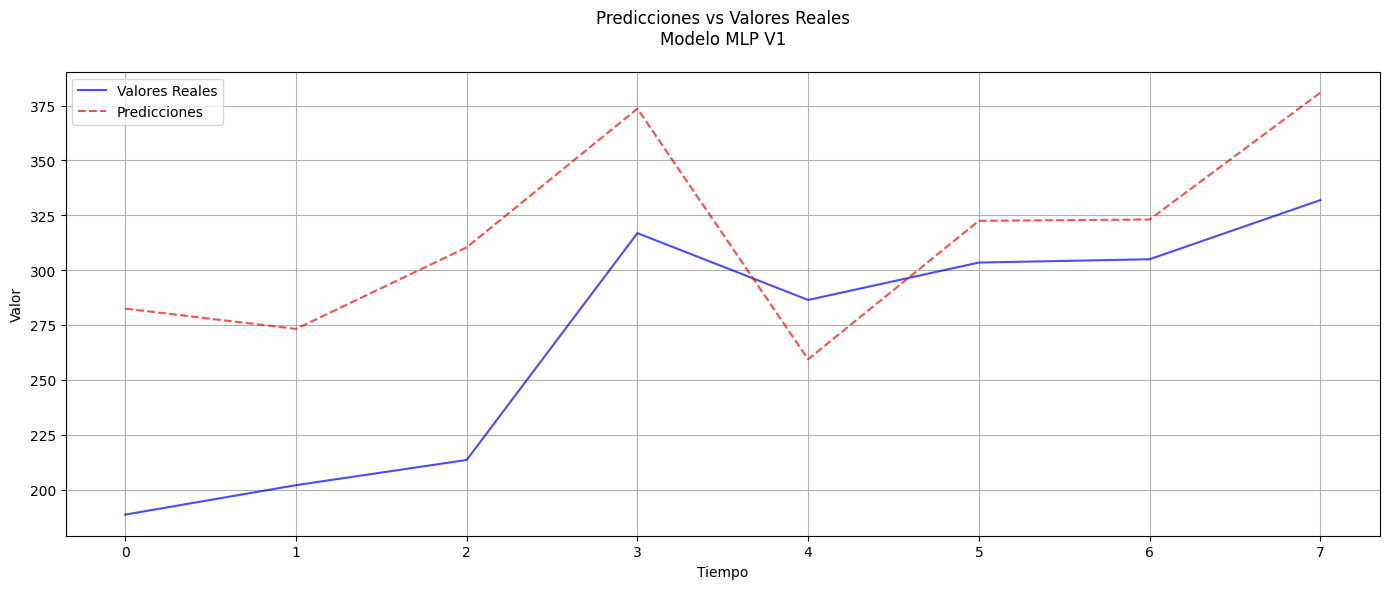


MLP - Versión 2
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 1.3073 - mae: 0.2905 - val_loss: 1.2095 - val_mae: 0.1787 - learning_rate: 5.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.2193 - mae: 0.1821 - val_loss: 1.1763 - val_mae: 0.1124 - learning_rate: 5.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1934 - mae: 0.1727 - val_loss: 1.1626 - val_mae: 0.1244 - learning_rate: 5.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1904 - mae: 0.2078 - val_loss: 1.1450 - val_mae: 0.1134 - learning_rate: 5.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1563 - mae: 0.1487 - val_loss: 1.1285 - val_mae: 0.1059 - learning_rate: 5.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1422 - mae: 0.1451 - val_loss: 1.1150 - val_mae: 0.1181 - learning_rate: 5.0000e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1220 - mae: 0.1302 - val_loss: 1.1027 - val_mae: 0.1313 - learni

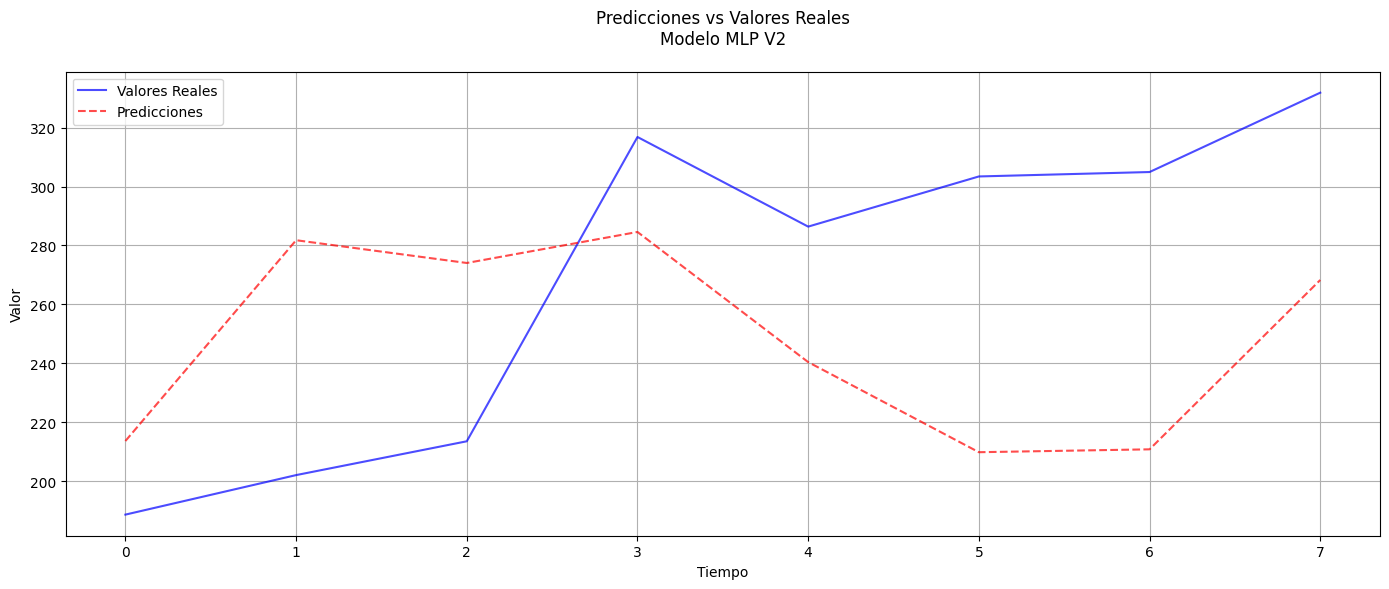


MLP - Versión 3
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.8672 - mae: 0.8848 - val_loss: 0.4891 - val_mae: 0.6735 - learning_rate: 1.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.6337 - mae: 0.7571 - val_loss: 0.3766 - val_mae: 0.5875 - learning_rate: 1.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.5366 - mae: 0.6787 - val_loss: 0.2862 - val_mae: 0.5075 - learning_rate: 1.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4442 - mae: 0.6110 - val_loss: 0.2166 - val_mae: 0.4358 - learning_rate: 1.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3509 - mae: 0.5365 - val_loss: 0.1675 - val_mae: 0.3758 - learning_rate: 1.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.3310 - mae: 0.4974 - val_loss: 0.1324 - val_mae: 0.3259 - learning_rate: 1.0000e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2364 - mae: 0.4030 - val_loss: 0.1057 - val_mae: 0.2812 - lear

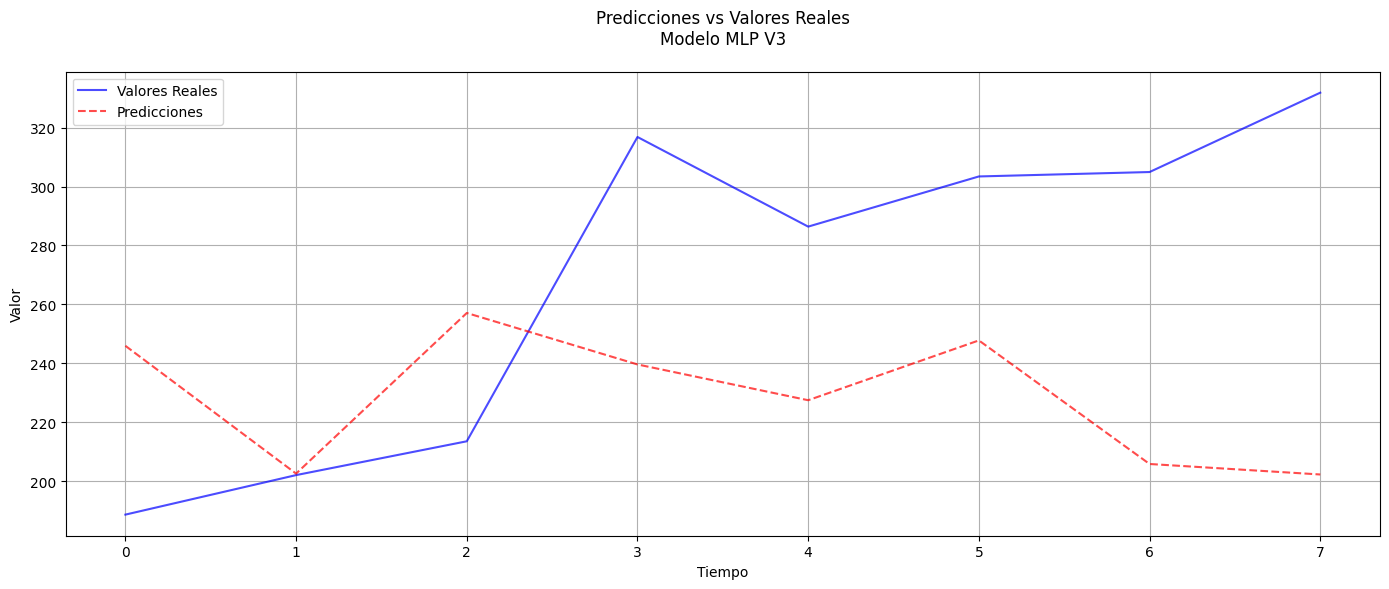


ENTRENANDO MODELOS CNN

CNN - Versión 1
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.2012 - mae: 0.3722 - val_loss: 0.0249 - val_mae: 0.1284 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0544 - mae: 0.1659 - val_loss: 0.0518 - val_mae: 0.2049 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0623 - mae: 0.2100 - val_loss: 0.0576 - val_mae: 0.2205 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0629 - mae: 0.2156 - val_loss: 0.0414 - val_mae: 0.1854 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0409 - mae: 0.1671 - val_loss: 0.0258 - val_mae: 0.1463 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0304 - mae: 0.1265 - val_loss: 0.0210 - val_mae: 0.1087 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0317 - mae: 0.1050 - val_loss: 0.0223 - val_mae: 0.0991 - learni

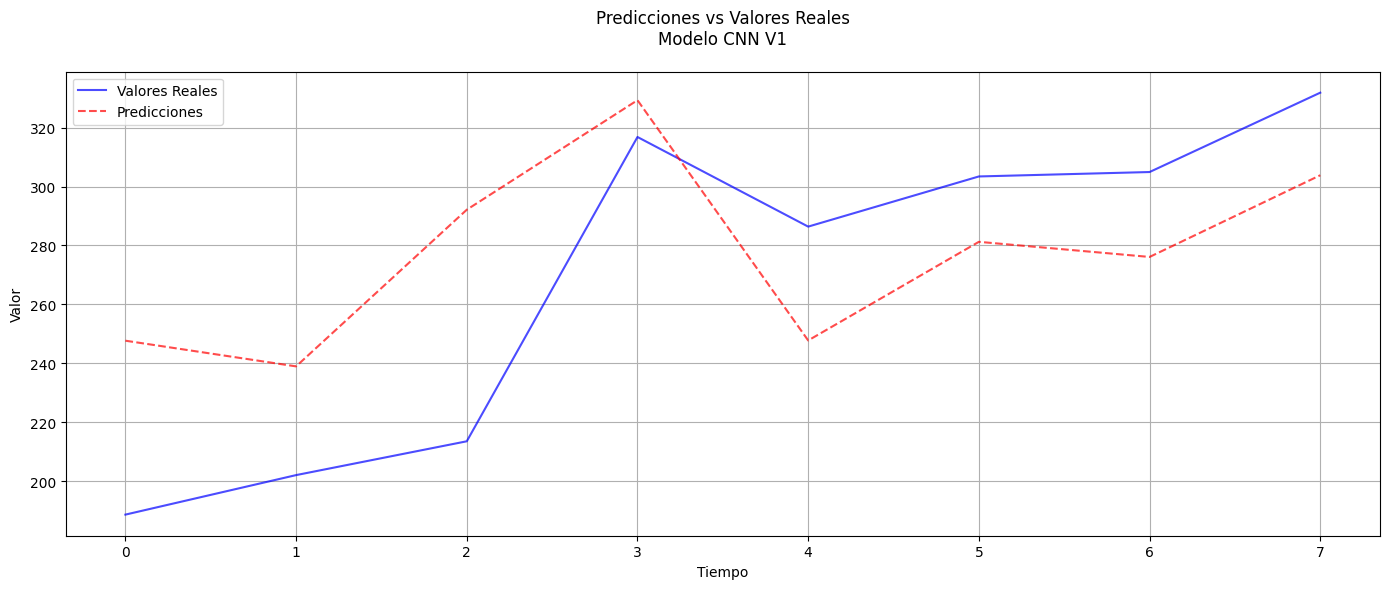


CNN - Versión 2
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.1083 - mae: 0.2610 - val_loss: 0.0344 - val_mae: 0.1554 - learning_rate: 5.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0455 - mae: 0.1385 - val_loss: 0.0194 - val_mae: 0.1140 - learning_rate: 5.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0417 - mae: 0.1565 - val_loss: 0.0237 - val_mae: 0.1317 - learning_rate: 5.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0563 - mae: 0.1970 - val_loss: 0.0217 - val_mae: 0.1282 - learning_rate: 5.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0494 - mae: 0.1753 - val_loss: 0.0187 - val_mae: 0.1187 - learning_rate: 5.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0418 - mae: 0.1720 - val_loss: 0.0176 - val_mae: 0.1059 - learning_rate: 5.0000e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0360 - mae: 0.1460 - val_loss: 0.0188 - val_mae: 0.0967 - learnin

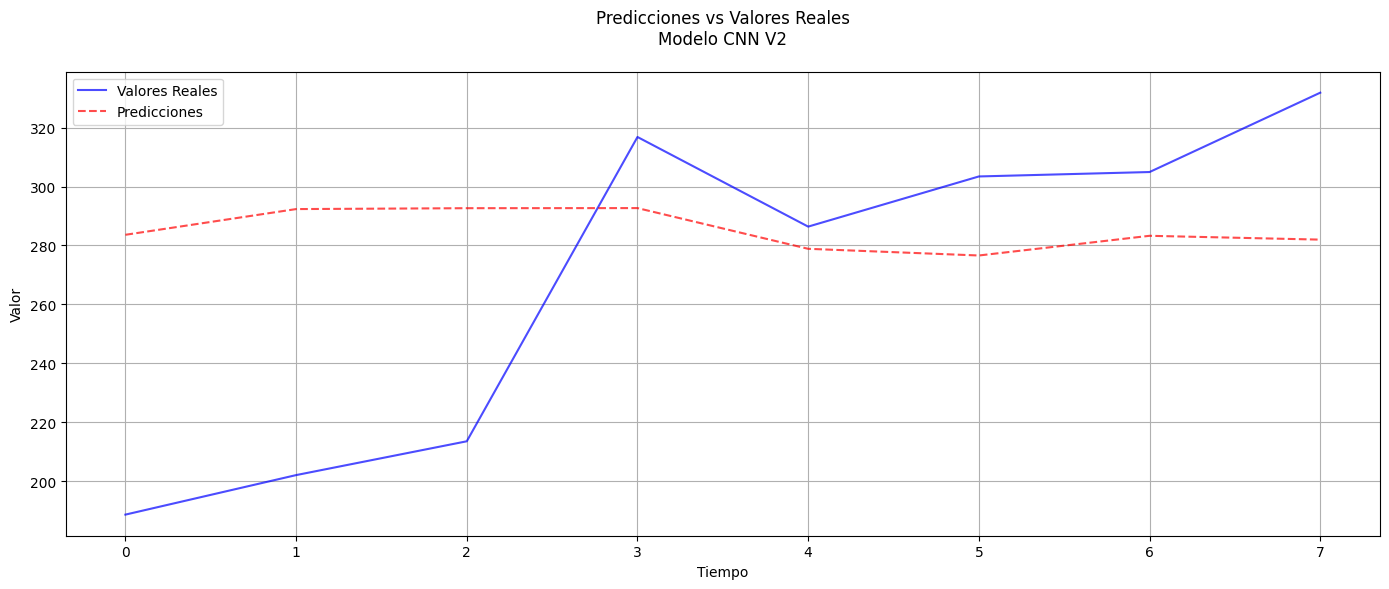


CNN - Versión 3
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - loss: 1.4849 - mae: 0.5737 - val_loss: 1.2872 - val_mae: 0.4048 - learning_rate: 1.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.3738 - mae: 0.4768 - val_loss: 1.2558 - val_mae: 0.3699 - learning_rate: 1.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.3313 - mae: 0.4363 - val_loss: 1.2301 - val_mae: 0.3389 - learning_rate: 1.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.3313 - mae: 0.4284 - val_loss: 1.2102 - val_mae: 0.3137 - learning_rate: 1.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.2828 - mae: 0.3843 - val_loss: 1.1939 - val_mae: 0.2918 - learning_rate: 1.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.2655 - mae: 0.3675 - val_loss: 1.1800 - val_mae: 0.2725 - learning_rate: 1.0000e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.2467 - mae: 0.3321 - val_loss: 1.1678 - val_mae: 0.2550 - learnin

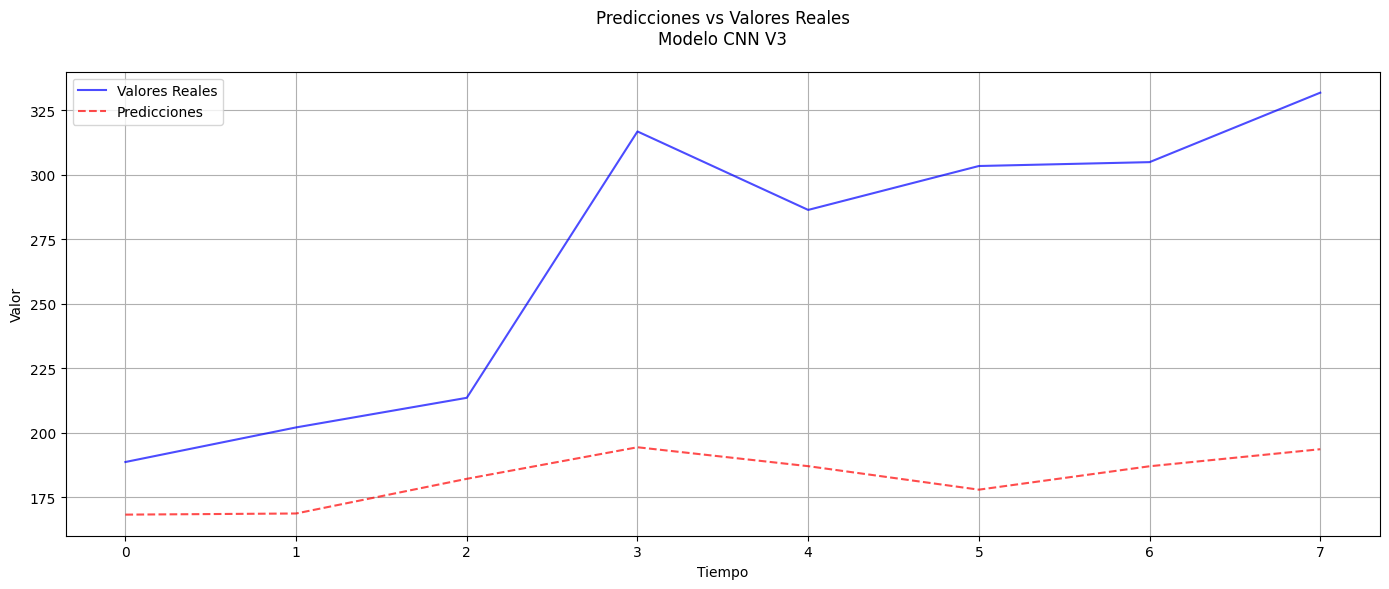


ENTRENANDO MODELOS LSTM

LSTM - Versión 1
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step - loss: 0.0895 - mae: 0.2284 - val_loss: 0.0267 - val_mae: 0.1164 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0403 - mae: 0.1403 - val_loss: 0.0189 - val_mae: 0.1147 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0361 - mae: 0.1418 - val_loss: 0.0188 - val_mae: 0.1266 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0407 - mae: 0.1617 - val_loss: 0.0240 - val_mae: 0.1107 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0397 - mae: 0.1369 - val_loss: 0.0251 - val_mae: 0.1120 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0337 - mae: 0.1248 - val_loss: 0.0175 - val_mae: 0.1180 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0363 - mae: 0.1476 - val_loss: 0.0184 - val_mae: 0.1073 - lea

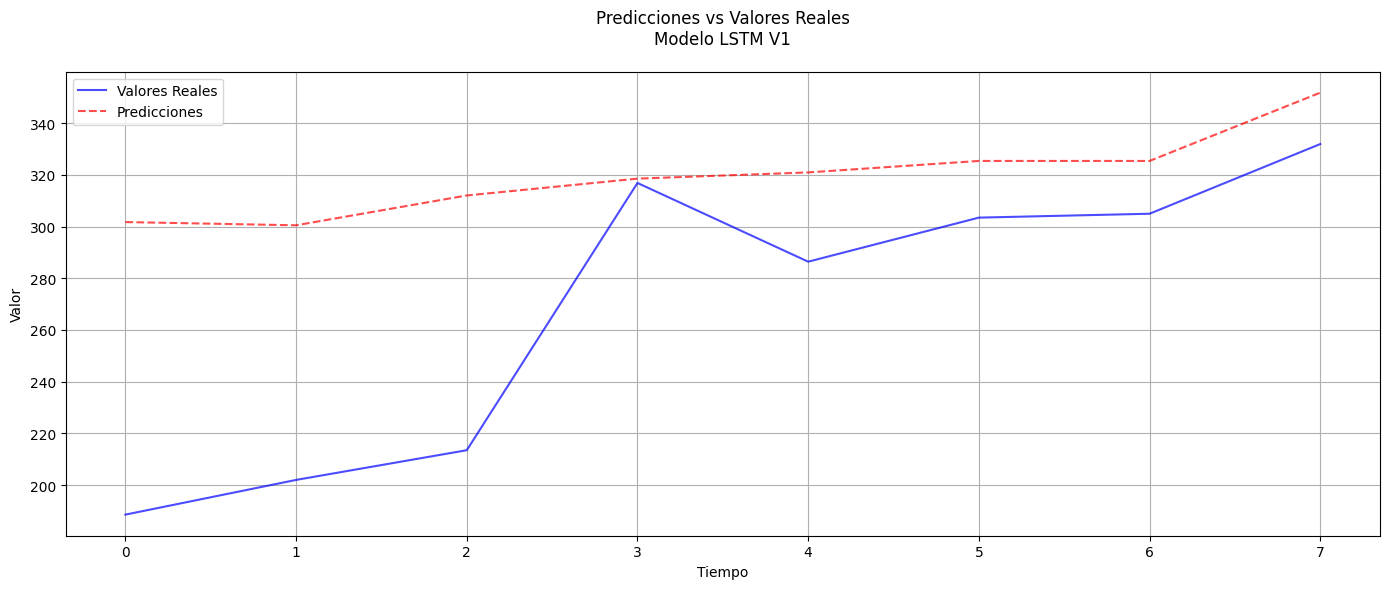


LSTM - Versión 2
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 864ms/step - loss: 0.1450 - mae: 0.3302 - val_loss: 0.0443 - val_mae: 0.1697 - learning_rate: 5.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0630 - mae: 0.1765 - val_loss: 0.0204 - val_mae: 0.0986 - learning_rate: 5.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0323 - mae: 0.1249 - val_loss: 0.0175 - val_mae: 0.1227 - learning_rate: 5.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0357 - mae: 0.1522 - val_loss: 0.0252 - val_mae: 0.1383 - learning_rate: 5.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0457 - mae: 0.1852 - val_loss: 0.0275 - val_mae: 0.1440 - learning_rate: 5.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0436 - mae: 0.1827 - val_loss: 0.0238 - val_mae: 0.1359 - learning_rate: 5.0000e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0428 - mae: 0.1775 - val_loss: 0.0181 - val_mae: 0.1249 - 

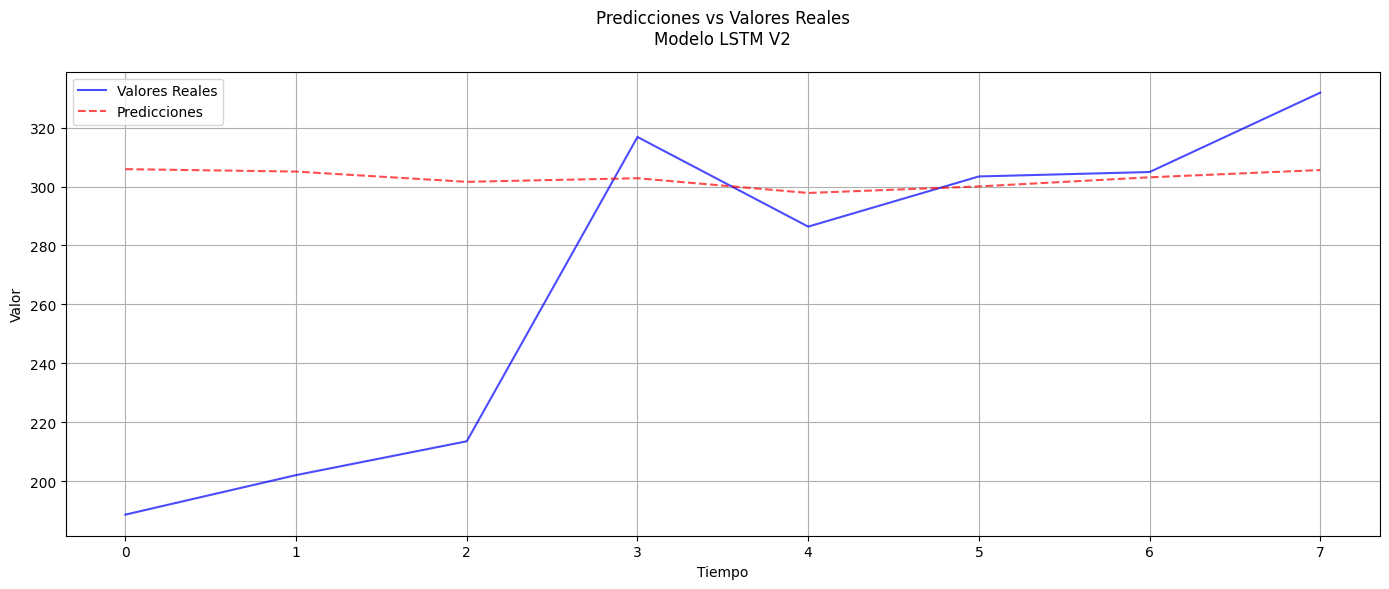


LSTM - Versión 3
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 576ms/step - loss: 0.4072 - mae: 0.4163 - val_loss: 0.3575 - val_mae: 0.3782 - learning_rate: 1.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3936 - mae: 0.4000 - val_loss: 0.3522 - val_mae: 0.3715 - learning_rate: 1.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3946 - mae: 0.3995 - val_loss: 0.3468 - val_mae: 0.3645 - learning_rate: 1.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3748 - mae: 0.3807 - val_loss: 0.3418 - val_mae: 0.3580 - learning_rate: 1.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3821 - mae: 0.3867 - val_loss: 0.3373 - val_mae: 0.3520 - learning_rate: 1.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3795 - mae: 0.3820 - val_loss: 0.3332 - val_mae: 0.3465 - learning_rate: 1.0000e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3749 - mae: 0.3773 - val_loss: 0.3295 - val_mae: 0.3415 - lear

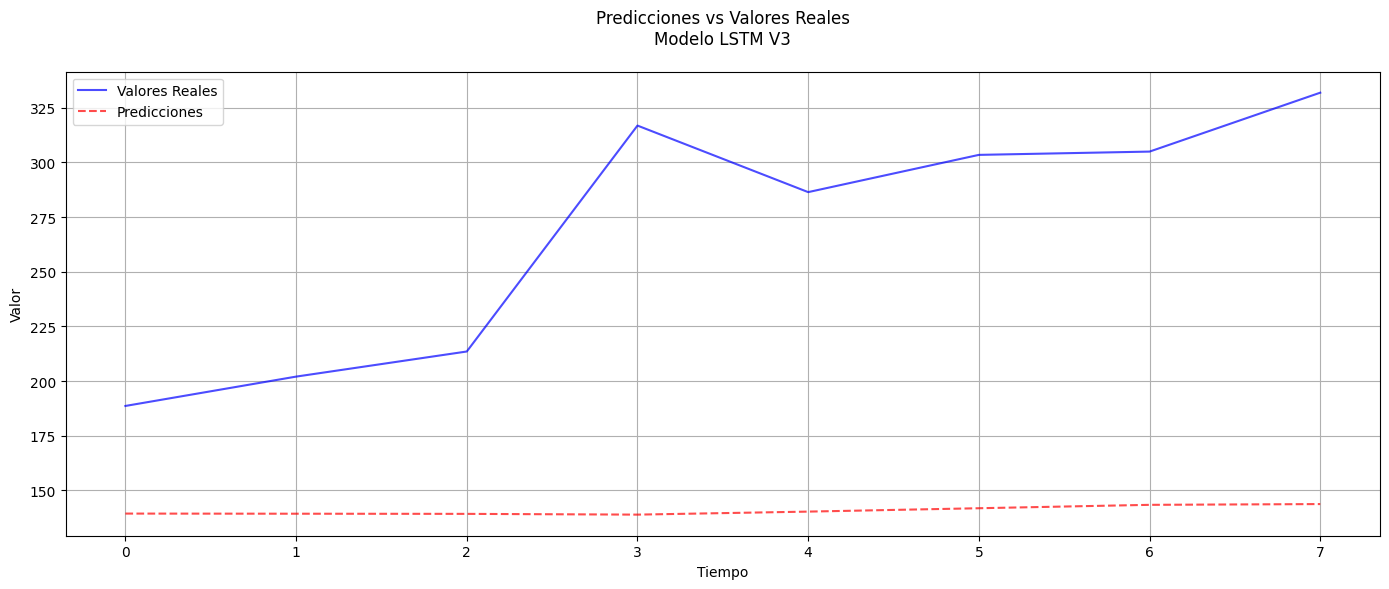


ENTRENANDO MODELOS CNN-LSTM

CNN-LSTM - Versión 1
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 740ms/step - loss: 0.2115 - mae: 0.4168 - val_loss: 0.0396 - val_mae: 0.1596 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0526 - mae: 0.1723 - val_loss: 0.0234 - val_mae: 0.1160 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0340 - mae: 0.1374 - val_loss: 0.0214 - val_mae: 0.1155 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0368 - mae: 0.1422 - val_loss: 0.0211 - val_mae: 0.1169 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0348 - mae: 0.1383 - val_loss: 0.0211 - val_mae: 0.1144 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0345 - mae: 0.1366 - val_loss: 0.0205 - val_mae: 0.1134 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0305 - mae: 0.1314 - val_loss: 0.0251 - val_mae: 0.134

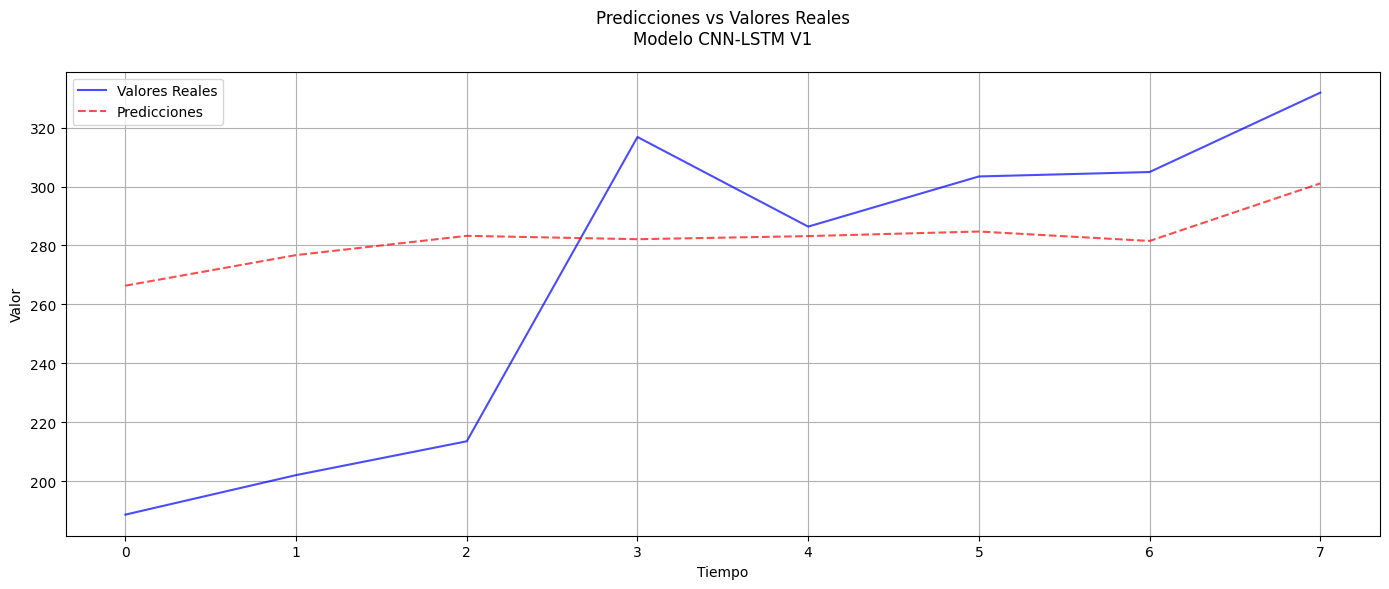


CNN-LSTM - Versión 2
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 606ms/step - loss: 0.1557 - mae: 0.3472 - val_loss: 0.0739 - val_mae: 0.2422 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1009 - mae: 0.2581 - val_loss: 0.0386 - val_mae: 0.1523 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0583 - mae: 0.1753 - val_loss: 0.0176 - val_mae: 0.1032 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0300 - mae: 0.1338 - val_loss: 0.0225 - val_mae: 0.1329 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0463 - mae: 0.1822 - val_loss: 0.0342 - val_mae: 0.1621 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0660 - mae: 0.2227 - val_loss: 0.0279 - val_mae: 0.1424 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0570 - mae: 0.2008 - val_loss: 0.0188 - val_mae: 0.1248 - learning_rate: 0.0010
Epo

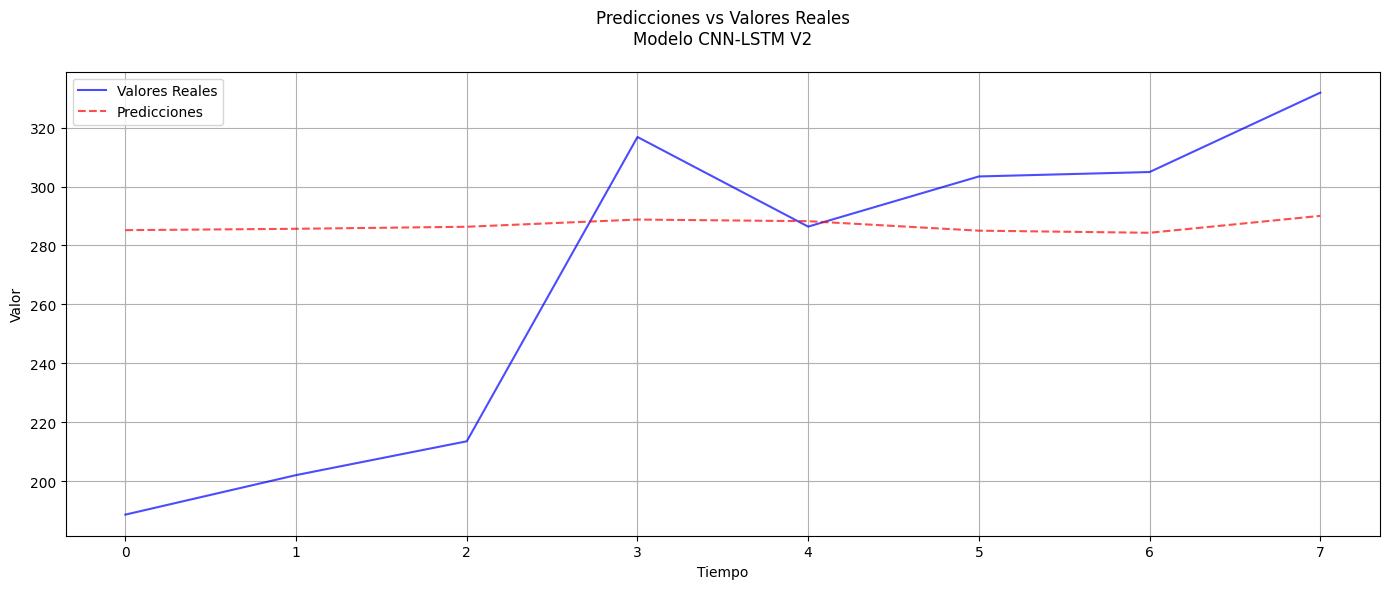


CNN-LSTM - Versión 3
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - loss: 0.1954 - mae: 0.3973 - val_loss: 0.0824 - val_mae: 0.2600 - learning_rate: 0.0010
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1160 - mae: 0.2876 - val_loss: 0.0436 - val_mae: 0.1698 - learning_rate: 0.0010
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0693 - mae: 0.1890 - val_loss: 0.0222 - val_mae: 0.1032 - learning_rate: 0.0010
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0430 - mae: 0.1431 - val_loss: 0.0162 - val_mae: 0.0990 - learning_rate: 0.0010
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0350 - mae: 0.1329 - val_loss: 0.0155 - val_mae: 0.1016 - learning_rate: 0.0010
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0343 - mae: 0.1366 - val_loss: 0.0162 - val_mae: 0.0955 - learning_rate: 0.0010
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0352 - mae: 0.1342 - val_loss: 0.0171 - val_mae: 0.0912 - learning_rate: 0.0010
Epoc

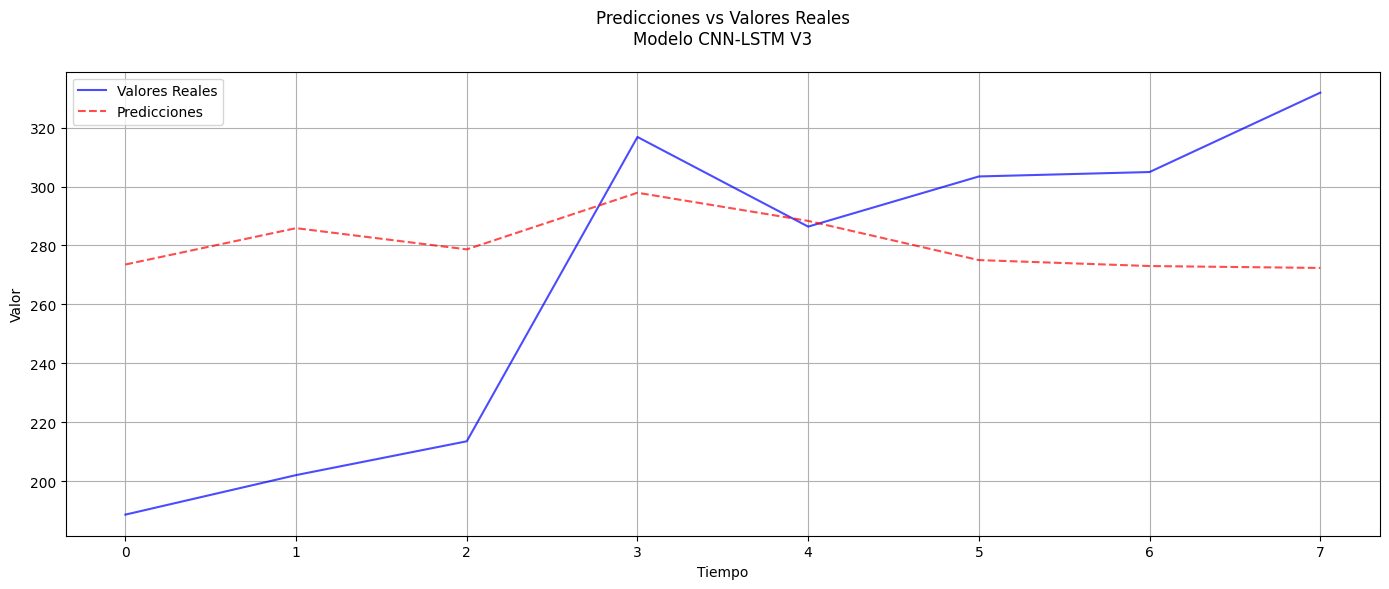


MEJOR MODELO GLOBAL: CNN V1
RMSE: 43.0094

Comparación de Modelos:
     Modelo       RMSE        MAE  MAPE      R2
     MLP-V1  61.535884  53.967701 0.23% -0.3140
     MLP-V2  66.612796  61.878411 0.24% -0.5397
     MLP-V3  74.475807  65.263978 0.23% -0.9247
     CNN-V1  43.009368  38.108962 0.16%  0.3581
     CNN-V2  58.927928  49.328194 0.22% -0.2049
     CNN-V3  97.625619  86.136621 0.30% -2.3071
    LSTM-V1  65.843563  51.060665 0.23% -0.5044
    LSTM-V2  64.408558  45.675828 0.22% -0.4395
    LSTM-V3 138.086456 127.712970 0.45% -5.6165
CNN-LSTM-V1  49.445779  41.637162 0.18%  0.1516
CNN-LSTM-V2  55.838227  45.484685 0.20% -0.0819
CNN-LSTM-V3  55.030750  46.837915 0.20% -0.0508


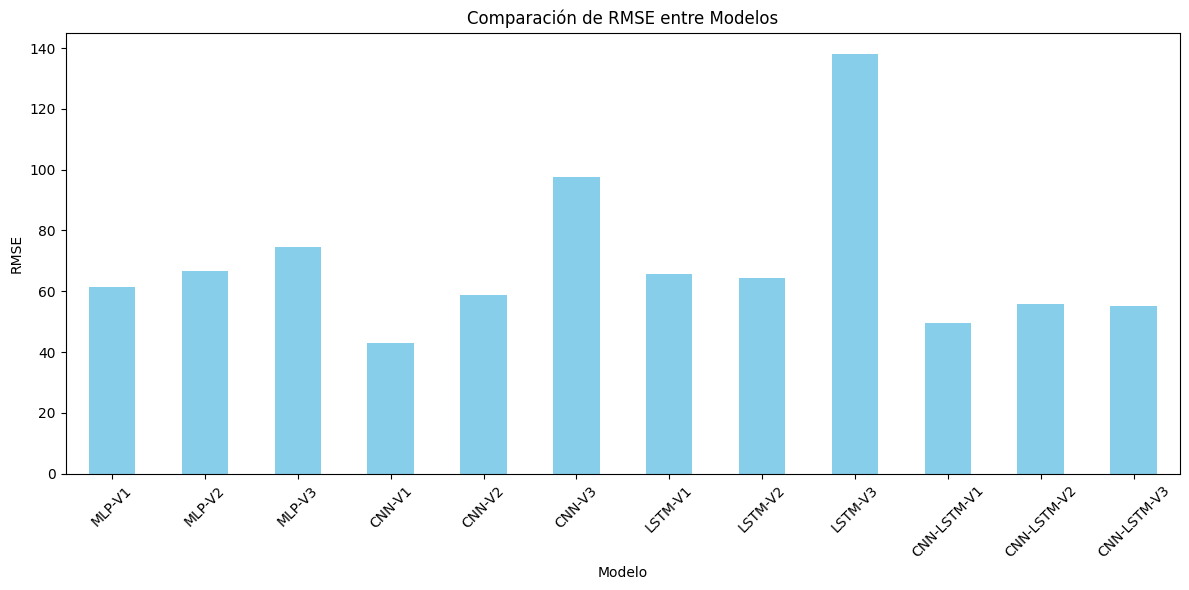

In [14]:
# Inicializar
forecaster = MultivariateForecaster('/content/drive/MyDrive/Daily_Demand_Forecasting_Orders.csv')

# Visualizar datos
forecaster.visualize_data()

# Entrenar y evaluar todos los modelos
results = forecaster.train_and_evaluate_all_models(n_steps=7, epochs=10)

# Comparar modelos
comparison = forecaster.compare_models()


# Acceder al mejor modelo
best_model = forecaster.best_model

## Optimización con optuna

In [10]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.3 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split

class MultivariateOrderForecaster:
    def __init__(self, data_path):
        """
        Inicializa el solucionador del examen con los datos multivariados.

        Parameters:
        data_path : str
            Ruta al archivo CSV con los datos de órdenes
        """
        # Cargar datos
        self.data = pd.read_csv(data_path, delimiter=';')

        # Preprocesamiento inicial
        self.preprocess_data()

        # Modelos
        self.models = {}
        self.histories = {}
        self.scalers = {}
        self.best_models = {}

    def preprocess_data(self):
        """
        Preprocesamiento básico de los datos.
        """
        # Verificar y limpiar datos
        print("Datos originales:")
        print(self.data.head())
        print("\nInformación del dataset:")
        print(self.data.info())

        # Eliminar filas con valores faltantes si las hay
        self.data = self.data.dropna()

        # Separar características y target
        self.features = self.data.drop(columns=['Target (Total orders)'])
        self.target = self.data['Target (Total orders)']

        # Convertir a numpy arrays
        self.X = self.features.values
        self.y = self.target.values.reshape(-1, 1)

    def visualize_data(self):
        """
        Visualización de las series multivariadas.
        """
        plt.figure(figsize=(15, 10))

        # Visualizar cada característica
        for i, col in enumerate(self.features.columns):
            plt.subplot(4, 4, i+1)
            plt.plot(self.features[col], label=col)
            plt.title(col)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Visualizar target
        plt.figure(figsize=(12, 6))
        plt.plot(self.target, label='Total Orders (Target)')
        plt.title("Serie Temporal del Target (Total de Órdenes)")
        plt.xlabel("Tiempo")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True)
        plt.show()

    def create_multivariate_sequences(self, data, target, n_steps):
        """
        Crea secuencias multivariadas para el modelo.

        Parameters:
        data : array
            Datos multivariados (features)
        target : array
            Variable objetivo
        n_steps : int
            Número de pasos temporales en cada secuencia

        Returns:
        tuple
            (X, y) arrays para entrenamiento
        """
        X, y = [], []
        for i in range(len(data) - n_steps):
            X.append(data[i:i+n_steps])
            y.append(target[i+n_steps])
        return np.array(X), np.array(y)

    def split_data(self, n_steps=7, test_size=0.15):
        """
        Divide los datos en entrenamiento, validación y prueba.

        Parameters:
        n_steps : int
            Número de pasos temporales a usar como ventana
        test_size : float
            Porcentaje de datos a usar como prueba (será dividido en val y test)

        Returns:
        tuple
            (X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y)
        """
        # Escalar características
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler_X.fit_transform(self.X)

        # Escalar target
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        y_scaled = scaler_y.fit_transform(self.y)

        # Crear secuencias
        X_seq, y_seq = self.create_multivariate_sequences(X_scaled, y_scaled, n_steps)

        # División 70-15-15
        # Primero separar train (70%) y temp (30%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_seq, y_seq, test_size=0.3, random_state=42, shuffle=False
        )

        # Luego dividir temp en val (15%) y test (15%)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
        )

        print(f"\nDivision de datos:")
        print(f"Train: {X_train.shape}, {y_train.shape}")
        print(f"Val: {X_val.shape}, {y_val.shape}")
        print(f"Test: {X_test.shape}, {y_test.shape}")

        return X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y

    def build_mlp(self, input_shape, n_units=64, dropout_rate=0.2, learning_rate=0.001):
        """
        Construye un modelo MLP para datos multivariados.
        """
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(n_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(n_units//2, activation='relu'),
            Dropout(dropout_rate),
            Dense(n_units//4, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def build_cnn(self, input_shape, filters=64, kernel_size=3, pool_size=2, learning_rate=0.001):
        """
        Construye un modelo CNN para datos multivariados.
        """
        model = Sequential([
            Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=pool_size),
            Conv1D(filters=filters//2, kernel_size=kernel_size, activation='relu'),
            MaxPooling1D(pool_size=pool_size),
            Flatten(),
            Dense(100, activation='relu'),
            Dense(50, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def build_cnn(self, input_shape, filters=64, kernel_size=3, pool_size=2, learning_rate=0.001):
      """
      Construye un modelo CNN para datos multivariados con protección contra reducción excesiva de dimensiones.
      """
      model = Sequential()
      model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                    activation='relu', input_shape=input_shape))

    # Solo agregar pooling si no reduce demasiado las dimensiones
      if input_shape[0] - kernel_size + 1 > pool_size:
          model.add(MaxPooling1D(pool_size=pool_size))
          remaining_steps = (input_shape[0] - kernel_size + 1) // pool_size
      else:
          remaining_steps = input_shape[0] - kernel_size + 1

    # Solo agregar segunda capa convolucional si hay suficiente dimensión temporal
      if remaining_steps > kernel_size:
          model.add(Conv1D(filters=filters//2, kernel_size=kernel_size, activation='relu'))
          if (remaining_steps - kernel_size + 1) > pool_size:
              model.add(MaxPooling1D(pool_size=pool_size))

      model.add(Flatten())
      model.add(Dense(100, activation='relu'))
      model.add(Dense(50, activation='relu'))
      model.add(Dense(1))

      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
      return model

    def build_lstm(self, input_shape, units=50, learning_rate=0.001):
        """
        Construye un modelo LSTM para datos multivariados.
        """
        model = Sequential([
            LSTM(units, return_sequences=True, input_shape=input_shape),
            LSTM(units//2),
            Dense(50, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def build_cnn_lstm(self, input_shape, cnn_filters=64, lstm_units=50, learning_rate=0.001):
        """
        Construye un modelo CNN-LSTM híbrido para datos multivariados.
        """
        model = Sequential([
            TimeDistributed(Conv1D(filters=cnn_filters, kernel_size=3, activation='relu')),
            TimeDistributed(MaxPooling1D(pool_size=2)),
            TimeDistributed(Flatten()),
            LSTM(lstm_units),
            Dense(50, activation='relu'),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def build_cnn_lstm(self, input_shape, cnn_filters=64, lstm_units=50, learning_rate=0.001):
      """
      Construye un modelo CNN-LSTM híbrido para datos multivariados corregido.
      """
      model = Sequential()

      # Reshape los datos para que sean 4D (batch, steps, features, 1) para Conv1D
      model.add(tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1),
                                     input_shape=input_shape))

      # Capa TimeDistributed Conv1D
      model.add(TimeDistributed(
          Conv1D(filters=cnn_filters, kernel_size=3, activation='relu'),
          input_shape=(input_shape[0], input_shape[1], 1)
      ))

      # Capa TimeDistributed MaxPooling1D
      model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

      # Capa TimeDistributed Flatten
      model.add(TimeDistributed(Flatten()))

      # Capa LSTM
      model.add(LSTM(lstm_units))

      # Capas densas finales
      model.add(Dense(50, activation='relu'))
      model.add(Dense(1))

      model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
      return model

    def train_model(self, model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, verbose=1):
        """
        Entrena un modelo y devuelve su historial.
        """
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=verbose
        )
        return history

    def evaluate_model(self, model, X_test, y_test, scaler_y):
        """
        Evalúa un modelo en los datos de prueba y muestra métricas.
        """
        # Predecir
        y_pred = model.predict(X_test)

        # Invertir escalado
        y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
        y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

        # Calcular métricas
        mse = mean_squared_error(y_test_inv, y_pred_inv)
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
        r2 = r2_score(y_test_inv, y_pred_inv)

        print("\nEvaluación del modelo:")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.4%}")
        print(f"R²: {r2:.4f}")

        # Graficar
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_inv, label='Real')
        plt.plot(y_pred_inv, label='Predicción')
        plt.title("Predicciones vs Valores Reales")
        plt.legend()
        plt.grid(True)
        plt.show()

        return {'mse': mse, 'mae': mae, 'mape': mape, 'r2': r2}

    def objective(self, trial, model_type, X_train, y_train, X_val, y_val):
        """
        Función objetivo para Optuna.
        """
        # Espacio de búsqueda común
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        if model_type == 'mlp':
            n_units = trial.suggest_int('n_units', 32, 256)
            dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

            model = self.build_mlp(
                input_shape=X_train.shape[1:],
                n_units=n_units,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate
            )

        elif model_type == 'cnn':
            filters = trial.suggest_int('filters', 32, 128)
            kernel_size = trial.suggest_int('kernel_size', 2, 5)

            model = self.build_cnn(
                input_shape=X_train.shape[1:],
                filters=filters,
                kernel_size=kernel_size,
                learning_rate=learning_rate
            )

        elif model_type == 'lstm':
            units = trial.suggest_int('units', 32, 128)

            model = self.build_lstm(
                input_shape=X_train.shape[1:],
                units=units,
                learning_rate=learning_rate
            )

        elif model_type == 'cnn_lstm':
            cnn_filters = trial.suggest_int('cnn_filters', 32, 128)
            lstm_units = trial.suggest_int('lstm_units', 32, 128)

            model = self.build_cnn_lstm(
                input_shape=X_train.shape[1:],
                cnn_filters=cnn_filters,
                lstm_units=lstm_units,
                learning_rate=learning_rate
            )

        elif model_type == 'cnn_lstm':
            cnn_filters = trial.suggest_int('cnn_filters', 32, 128)
            lstm_units = trial.suggest_int('lstm_units', 32, 128)

            # Asegurar que el kernel_size no sea mayor que los pasos temporales
            kernel_size = min(3, X_train.shape[1] - 1)

            model = self.build_cnn_lstm(
                input_shape=X_train.shape[1:],
                cnn_filters=cnn_filters,
                lstm_units=lstm_units,
                learning_rate=learning_rate
            )

        # Entrenamiento con early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, verbose=0
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

        return min(history.history['val_loss'])

    def optimize_model(self, model_type, X_train, y_train, X_val, y_val, n_trials=30):
        """
        Optimiza un modelo usando Optuna.
        """
        study = optuna.create_study(
            direction='minimize',
            sampler=TPESampler(),
            pruner=optuna.pruners.HyperbandPruner()
        )

        study.optimize(
            lambda trial: self.objective(trial, model_type, X_train, y_train, X_val, y_val),
            n_trials=n_trials,
            show_progress_bar=True
        )

        print(f"\nMejores hiperparámetros para {model_type}:")
        for key, value in study.best_params.items():
            print(f"{key}: {value}")

        return study.best_params

    def run_experiment(self, n_steps=7, n_trials=30):
        """
        Ejecuta el experimento completo.
        """
        print("="*50)
        print("ANÁLISIS DE DATOS")
        print("="*50)
        self.visualize_data()

        print("\n" + "="*50)
        print("DIVISIÓN DE DATOS")
        print("="*50)
        X_train, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = self.split_data(n_steps=n_steps)

        # Guardar scalers para uso posterior
        self.scalers = {'X': scaler_X, 'y': scaler_y}

        model_types = ['mlp', 'cnn', 'lstm', 'cnn_lstm']
        results = {}

        for model_type in model_types:
            print("\n" + "="*50)
            print(f"MODELO: {model_type.upper()}")
            print("="*50)

            # Optimización con Optuna
            print("\nOptimizando hiperparámetros...")
            best_params = self.optimize_model(
                model_type, X_train, y_train, X_val, y_val, n_trials=n_trials
            )

            # Construir modelo con mejores parámetros
            if model_type == 'mlp':
                model = self.build_mlp(
                    input_shape=X_train.shape[1:],
                    n_units=best_params['n_units'],
                    dropout_rate=best_params['dropout_rate'],
                    learning_rate=best_params['learning_rate']
                )

            elif model_type == 'cnn':
                model = self.build_cnn(
                    input_shape=X_train.shape[1:],
                    filters=best_params['filters'],
                    kernel_size=best_params['kernel_size'],
                    learning_rate=best_params['learning_rate']
                )

            elif model_type == 'lstm':
                model = self.build_lstm(
                    input_shape=X_train.shape[1:],
                    units=best_params['units'],
                    learning_rate=best_params['learning_rate']
                )

            elif model_type == 'cnn_lstm':
                model = self.build_cnn_lstm(
                    input_shape=X_train.shape[1:],
                    cnn_filters=best_params['cnn_filters'],
                    lstm_units=best_params['lstm_units'],
                    learning_rate=best_params['learning_rate']
                )

            # Entrenar modelo final
            print("\nEntrenando modelo final...")
            history = self.train_model(
                model, X_train, y_train, X_val, y_val,
                epochs=200, batch_size=best_params['batch_size']
            )

            # Evaluar modelo
            print("\nEvaluando modelo...")
            metrics = self.evaluate_model(model, X_test, y_test, scaler_y)

            # Guardar resultados
            results[model_type] = {
                'model': model,
                'history': history,
                'metrics': metrics,
                'params': best_params
            }

            # Guardar el mejor modelo hasta ahora
            if not self.best_models or metrics['mae'] < self.best_models['metrics']['mae']:
                self.best_models = {
                    'type': model_type,
                    'model': model,
                    'metrics': metrics,
                    'params': best_params
                }

        self.models = results
        return results

    def get_best_model(self):
        """
        Devuelve el mejor modelo encontrado.
        """
        if not self.best_models:
            raise ValueError("No se han entrenado modelos todavía. Ejecuta run_experiment() primero.")

        print(f"\nMejor modelo: {self.best_models['type'].upper()}")
        print("Métricas:")
        for metric, value in self.best_models['metrics'].items():
            print(f"{metric}: {value:.4f}")

        return self.best_models

Datos originales:
   Week of the month (first week, second, third, fourth or fifth week  \
0                                                  1                    
1                                                  1                    
2                                                  1                    
3                                                  2                    
4                                                  2                    

   Day of the week (Monday to Friday)  Non-urgent order  Urgent order  \
0                                   4           316.307       223.270   
1                                   5           128.633        96.042   
2                                   6            43.651        84.375   
3                                   2           171.297       127.667   
4                                   3            90.532       113.526   

   Order type A  Order type B  Order type C  Fiscal sector orders  \
0        61.543       175.586      

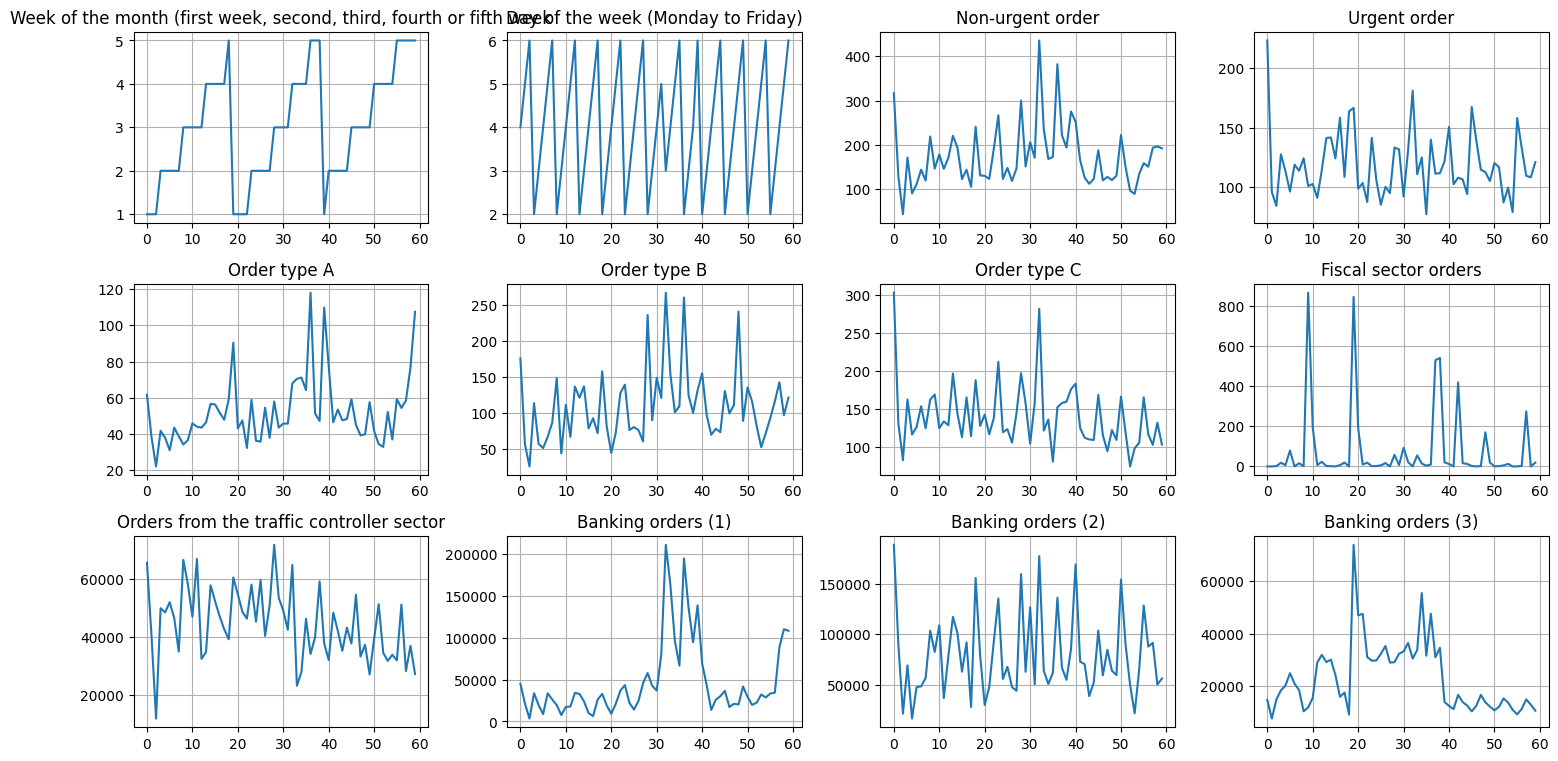

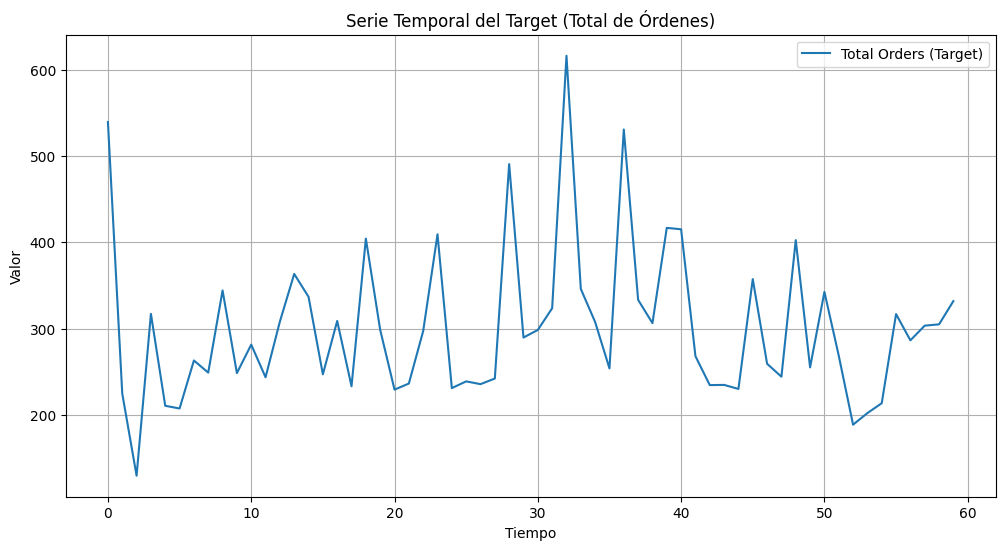

[I 2025-04-05 08:18:04,705] A new study created in memory with name: no-name-f99d6fc5-d0a1-409f-9e10-8f23903f25da



DIVISIÓN DE DATOS

Division de datos:
Train: (37, 7, 12), (37, 1)
Val: (8, 7, 12), (8, 1)
Test: (8, 7, 12), (8, 1)

MODELO: MLP

Optimizando hiperparámetros...


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-04-05 08:18:18,879] Trial 0 finished with value: 0.02957266755402088 and parameters: {'learning_rate': 7.738976661193775e-05, 'batch_size': 32, 'n_units': 33, 'dropout_rate': 0.24143442198944248}. Best is trial 0 with value: 0.02957266755402088.
[I 2025-04-05 08:18:21,390] Trial 1 finished with value: 0.013647090643644333 and parameters: {'learning_rate': 0.0030553475199361045, 'batch_size': 16, 'n_units': 235, 'dropout_rate': 0.14293670374595913}. Best is trial 1 with value: 0.013647090643644333.
[I 2025-04-05 08:18:27,729] Trial 2 finished with value: 0.025661535561084747 and parameters: {'learning_rate': 0.0006526317651210301, 'batch_size': 16, 'n_units': 151, 'dropout_rate': 0.2400715779001161}. Best is trial 1 with value: 0.013647090643644333.
[I 2025-04-05 08:18:35,664] Trial 3 finished with value: 0.017058568075299263 and parameters: {'learning_rate': 2.2883695926706647e-05, 'batch_size': 16, 'n_units': 227, 'dropout_rate': 0.3460329559425288}. Best is trial 1 with value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step

Evaluación del modelo:
MSE: 3241.4996
MAE: 44.3797
MAPE: 19.9953%
R²: -0.1248


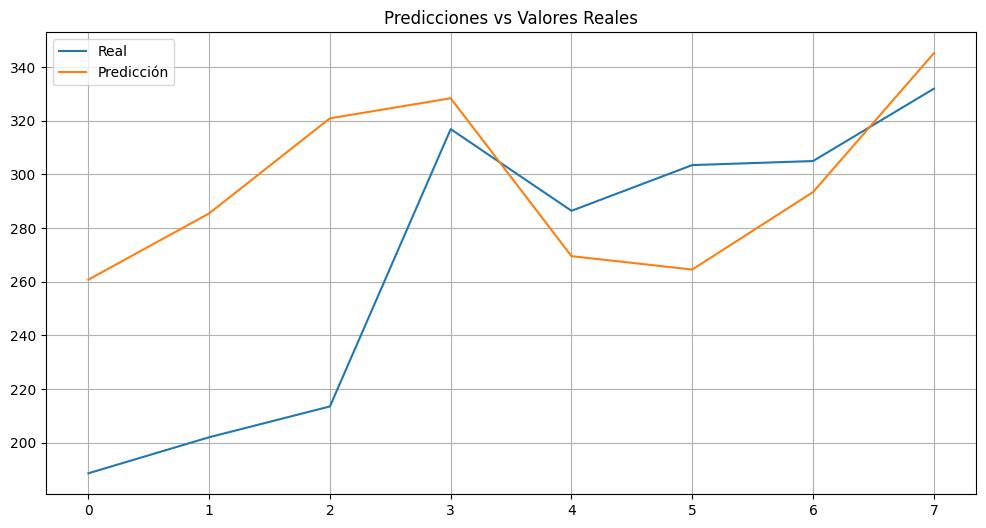

[I 2025-04-05 08:19:09,942] A new study created in memory with name: no-name-60e695a9-f5bf-40a9-8e03-420885706d36



MODELO: CNN

Optimizando hiperparámetros...


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-04-05 08:19:14,154] Trial 0 finished with value: 0.015598071739077568 and parameters: {'learning_rate': 0.00036943090397418047, 'batch_size': 32, 'filters': 48, 'kernel_size': 2}. Best is trial 0 with value: 0.015598071739077568.
[I 2025-04-05 08:19:25,681] Trial 1 finished with value: 0.01900155283510685 and parameters: {'learning_rate': 3.0004111559448114e-05, 'batch_size': 16, 'filters': 113, 'kernel_size': 4}. Best is trial 0 with value: 0.015598071739077568.
[I 2025-04-05 08:19:28,876] Trial 2 finished with value: 0.01311086118221283 and parameters: {'learning_rate': 0.0006323939928579625, 'batch_size': 64, 'filters': 76, 'kernel_size': 3}. Best is trial 2 with value: 0.01311086118221283.
[I 2025-04-05 08:19:36,637] Trial 3 finished with value: 0.022834820672869682 and parameters: {'learning_rate': 0.0001865876434270736, 'batch_size': 64, 'filters': 101, 'kernel_size': 3}. Best is trial 2 with value: 0.01311086118221283.
[I 2025-04-05 08:19:40,038] Trial 4 finished with va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

Evaluación del modelo:
MSE: 3914.6658
MAE: 59.6663
MAPE: 23.6711%
R²: -0.3584


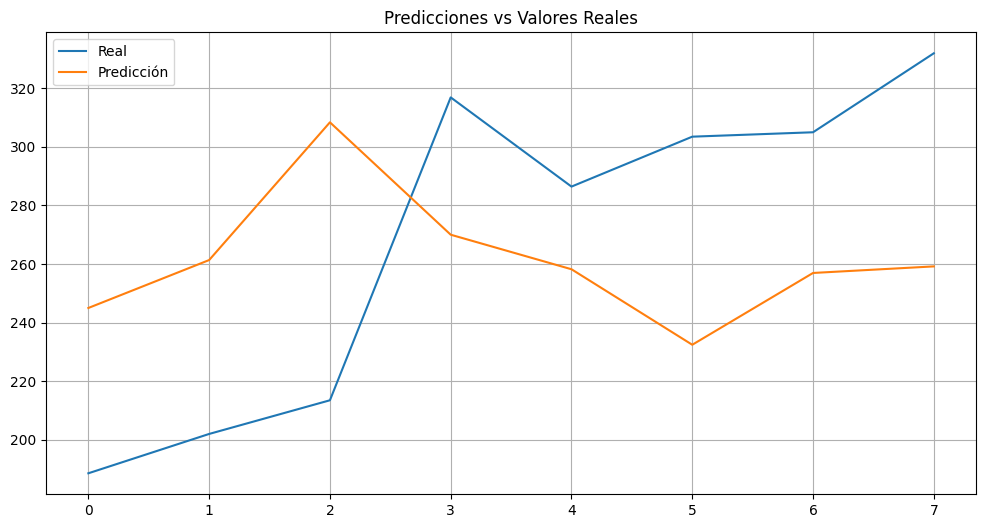

[I 2025-04-05 08:20:18,283] A new study created in memory with name: no-name-5839eab0-fb73-45a9-b2e5-cbc1ce95f274



MODELO: LSTM

Optimizando hiperparámetros...


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-04-05 08:20:35,844] Trial 0 finished with value: 0.05717422068119049 and parameters: {'learning_rate': 2.3241539434126765e-05, 'batch_size': 64, 'units': 72}. Best is trial 0 with value: 0.05717422068119049.
[I 2025-04-05 08:20:42,774] Trial 1 finished with value: 0.015982013195753098 and parameters: {'learning_rate': 0.003819790507917569, 'batch_size': 64, 'units': 63}. Best is trial 1 with value: 0.015982013195753098.
[I 2025-04-05 08:20:51,466] Trial 2 finished with value: 0.013456864282488823 and parameters: {'learning_rate': 0.0016753820342187118, 'batch_size': 32, 'units': 114}. Best is trial 2 with value: 0.013456864282488823.
[I 2025-04-05 08:21:11,892] Trial 3 finished with value: 0.03454330191016197 and parameters: {'learning_rate': 1.6009647738850254e-05, 'batch_size': 16, 'units': 92}. Best is trial 2 with value: 0.013456864282488823.
[I 2025-04-05 08:21:17,590] Trial 4 finished with value: 0.014961972832679749 and parameters: {'learning_rate': 0.0037604308161772976

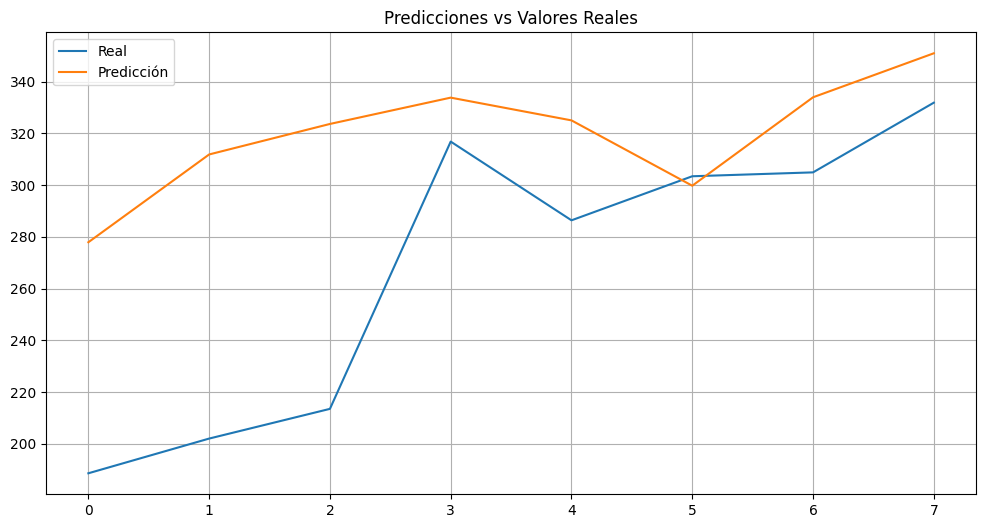

[I 2025-04-05 08:22:49,708] A new study created in memory with name: no-name-4ddde94c-e925-4b39-8a81-8a77b9809fea



MODELO: CNN_LSTM

Optimizando hiperparámetros...


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-04-05 08:22:57,355] Trial 0 finished with value: 0.017533348873257637 and parameters: {'learning_rate': 0.0006469640628404471, 'batch_size': 64, 'cnn_filters': 54, 'lstm_units': 100}. Best is trial 0 with value: 0.017533348873257637.
[I 2025-04-05 08:23:17,829] Trial 1 finished with value: 0.01684734970331192 and parameters: {'learning_rate': 3.2554645982485284e-05, 'batch_size': 32, 'cnn_filters': 86, 'lstm_units': 65}. Best is trial 1 with value: 0.01684734970331192.
[I 2025-04-05 08:23:24,624] Trial 2 finished with value: 0.016851026564836502 and parameters: {'learning_rate': 0.00368230024444426, 'batch_size': 64, 'cnn_filters': 79, 'lstm_units': 124}. Best is trial 1 with value: 0.01684734970331192.
[I 2025-04-05 08:23:31,022] Trial 3 finished with value: 0.016828838735818863 and parameters: {'learning_rate': 0.009317688095779514, 'batch_size': 32, 'cnn_filters': 76, 'lstm_units': 117}. Best is trial 3 with value: 0.016828838735818863.
[I 2025-04-05 08:23:38,272] Trial 4 fi

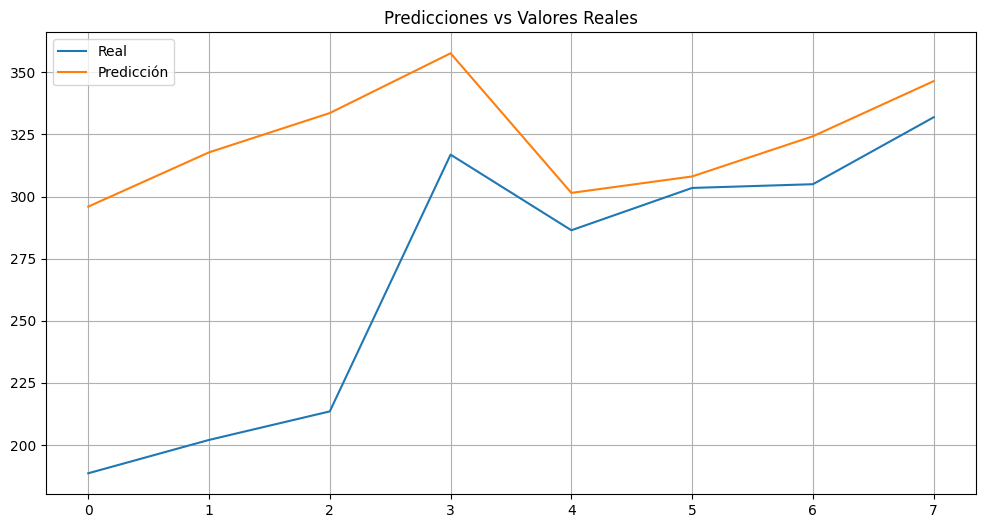


Mejor modelo: MLP
Métricas:
mse: 3241.4996
mae: 44.3797
mape: 0.2000
r2: -0.1248


In [20]:
# Inicializar el solucionador
forecaster = MultivariateOrderForecaster("/content/drive/MyDrive/Daily_Demand_Forecasting_Orders.csv")

# Ejecutar el experimento completo
results = forecaster.run_experiment(n_steps=7, n_trials=10)

# Obtener el mejor modelo
best_model = forecaster.get_best_model()

ANÁLISIS DE DATOS


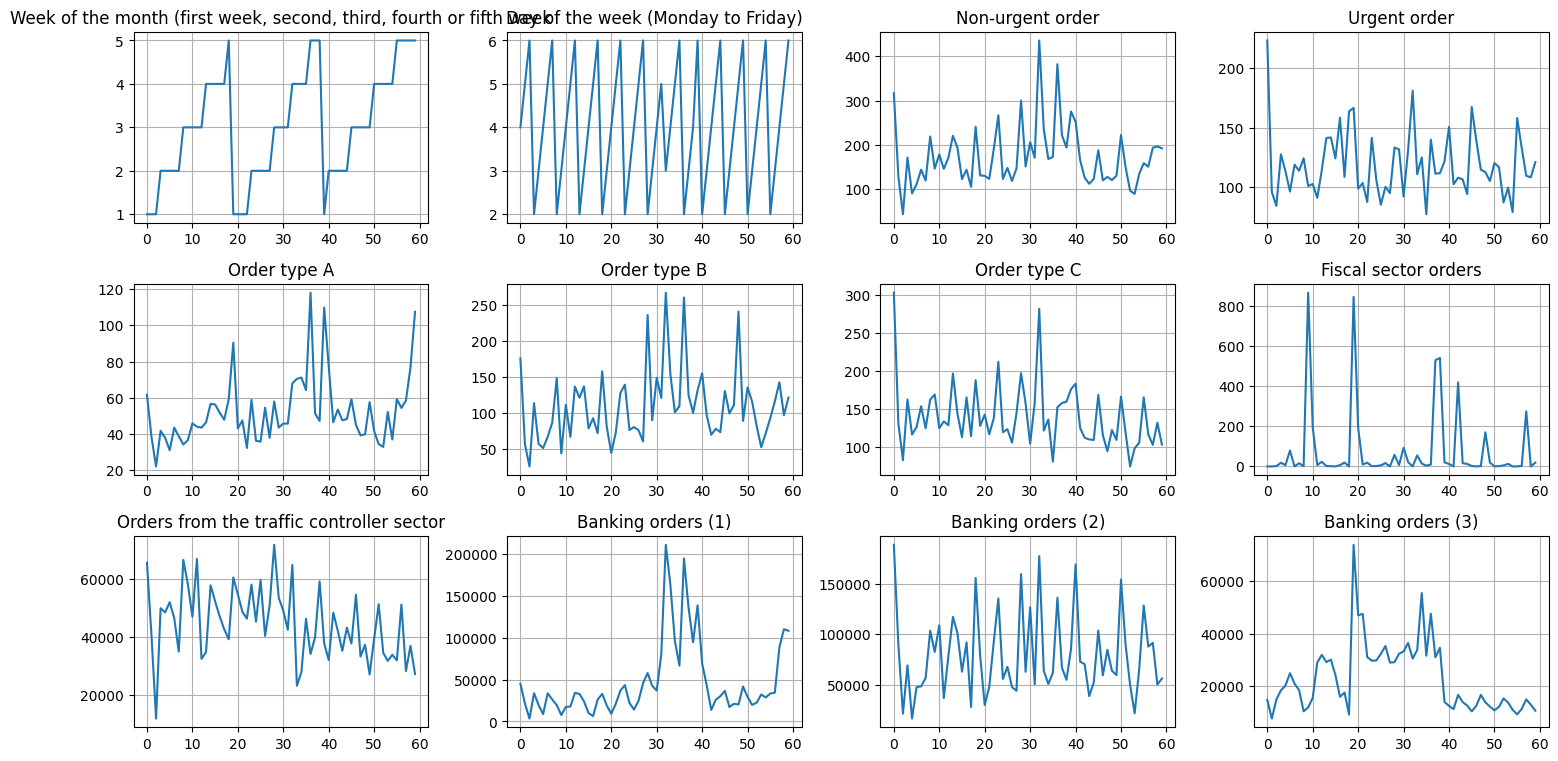

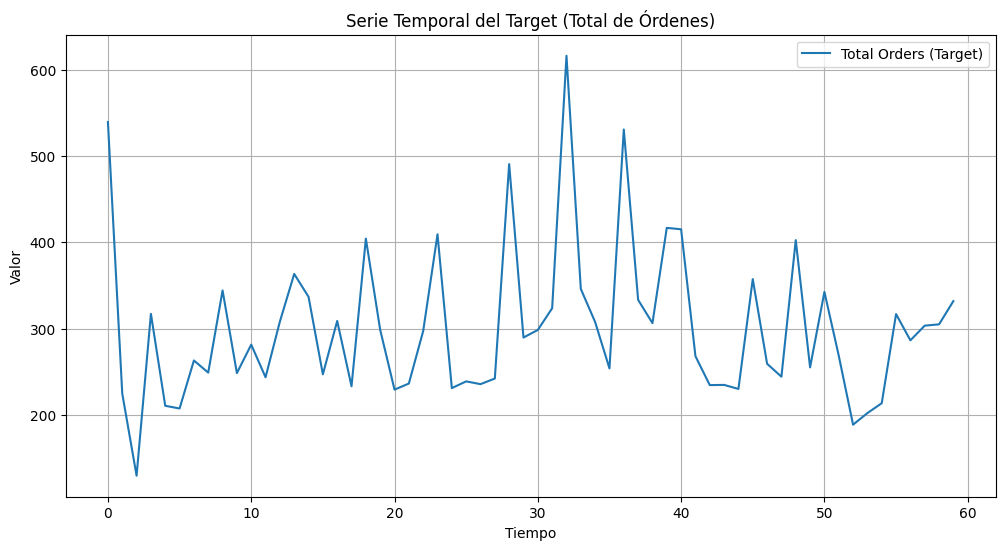

[I 2025-04-05 08:26:47,294] A new study created in memory with name: no-name-773c1a56-47c6-48e1-898e-000f2749f998



DIVISIÓN DE DATOS

Division de datos:
Train: (37, 7, 12), (37, 1)
Val: (8, 7, 12), (8, 1)
Test: (8, 7, 12), (8, 1)

MODELO: MLP

Optimizando hiperparámetros...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-04-05 08:26:51,083] Trial 0 finished with value: 0.029705384746193886 and parameters: {'learning_rate': 0.0011887755650628266, 'batch_size': 16, 'n_units': 217, 'dropout_rate': 0.4873713996196657}. Best is trial 0 with value: 0.029705384746193886.
[I 2025-04-05 08:26:55,240] Trial 1 finished with value: 0.020105669274926186 and parameters: {'learning_rate': 0.0008441703769358338, 'batch_size': 32, 'n_units': 91, 'dropout_rate': 0.15575806957205274}. Best is trial 1 with value: 0.020105669274926186.
[I 2025-04-05 08:27:01,754] Trial 2 finished with value: 0.015603386797010899 and parameters: {'learning_rate': 4.5872405864515184e-05, 'batch_size': 16, 'n_units': 173, 'dropout_rate': 0.3272643821981075}. Best is trial 2 with value: 0.015603386797010899.
[I 2025-04-05 08:27:06,360] Trial 3 finished with value: 0.02688291110098362 and parameters: {'learning_rate': 0.00024739824429801456, 'batch_size': 32, 'n_units': 48, 'dropout_rate': 0.2036431448628112}. Best is trial 2 with value

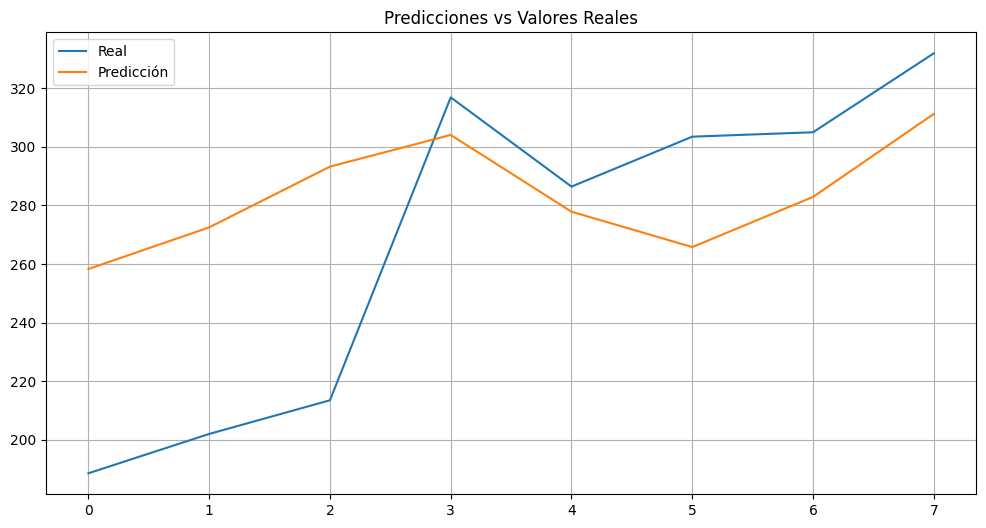

[I 2025-04-05 08:29:12,562] A new study created in memory with name: no-name-26457273-5fe0-4b42-9707-0b4be5e77a2c



MODELO: CNN

Optimizando hiperparámetros...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2025-04-05 08:29:16,055] Trial 0 finished with value: 0.0155648710206151 and parameters: {'learning_rate': 0.0007025279431955681, 'batch_size': 16, 'filters': 116, 'kernel_size': 4}. Best is trial 0 with value: 0.0155648710206151.
[I 2025-04-05 08:29:24,130] Trial 1 finished with value: 0.018153704702854156 and parameters: {'learning_rate': 7.246067189746699e-05, 'batch_size': 32, 'filters': 124, 'kernel_size': 4}. Best is trial 0 with value: 0.0155648710206151.
[I 2025-04-05 08:29:27,156] Trial 2 finished with value: 0.019482765346765518 and parameters: {'learning_rate': 0.001260931656599722, 'batch_size': 64, 'filters': 84, 'kernel_size': 4}. Best is trial 0 with value: 0.0155648710206151.
[I 2025-04-05 08:29:31,239] Trial 3 finished with value: 0.01890198141336441 and parameters: {'learning_rate': 0.0017050910811938359, 'batch_size': 64, 'filters': 50, 'kernel_size': 3}. Best is trial 0 with value: 0.0155648710206151.
[I 2025-04-05 08:29:46,870] Trial 4 finished with value: 0.014

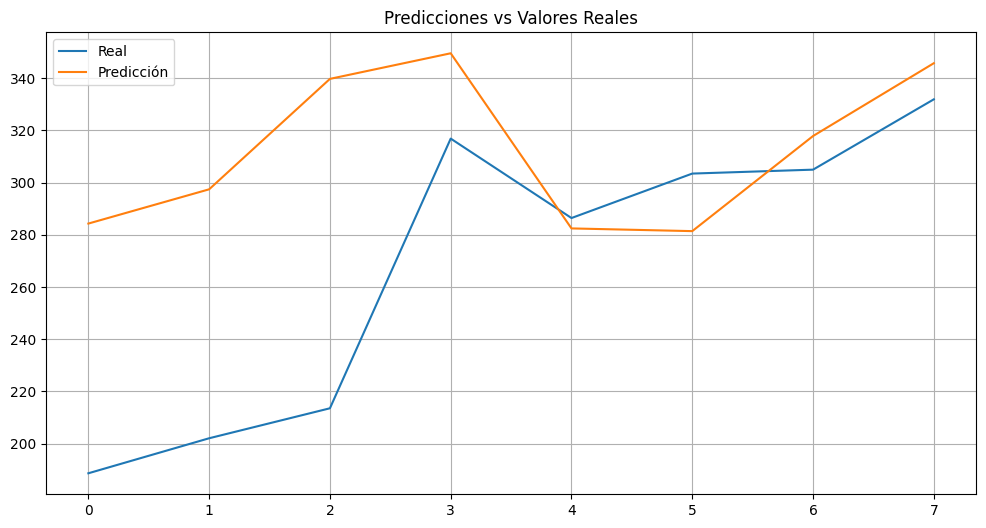

[I 2025-04-05 08:32:31,709] A new study created in memory with name: no-name-6a891b10-c7e2-421a-a204-63d1cf6068ed



MODELO: LSTM

Optimizando hiperparámetros...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-04-05 08:32:37,533] Trial 0 finished with value: 0.01741543784737587 and parameters: {'learning_rate': 0.0004272539830001228, 'batch_size': 16, 'units': 50}. Best is trial 0 with value: 0.01741543784737587.
[I 2025-04-05 08:32:44,761] Trial 1 finished with value: 0.017828065901994705 and parameters: {'learning_rate': 0.0006986863038779751, 'batch_size': 64, 'units': 80}. Best is trial 0 with value: 0.01741543784737587.
[I 2025-04-05 08:32:59,719] Trial 2 finished with value: 0.012923567555844784 and parameters: {'learning_rate': 0.0011452216322562262, 'batch_size': 16, 'units': 95}. Best is trial 2 with value: 0.012923567555844784.
[I 2025-04-05 08:33:15,362] Trial 3 finished with value: 0.014492111280560493 and parameters: {'learning_rate': 0.00016436003760274555, 'batch_size': 16, 'units': 44}. Best is trial 2 with value: 0.012923567555844784.
[I 2025-04-05 08:33:34,752] Trial 4 finished with value: 0.016493692994117737 and parameters: {'learning_rate': 3.812537992125106e-05,

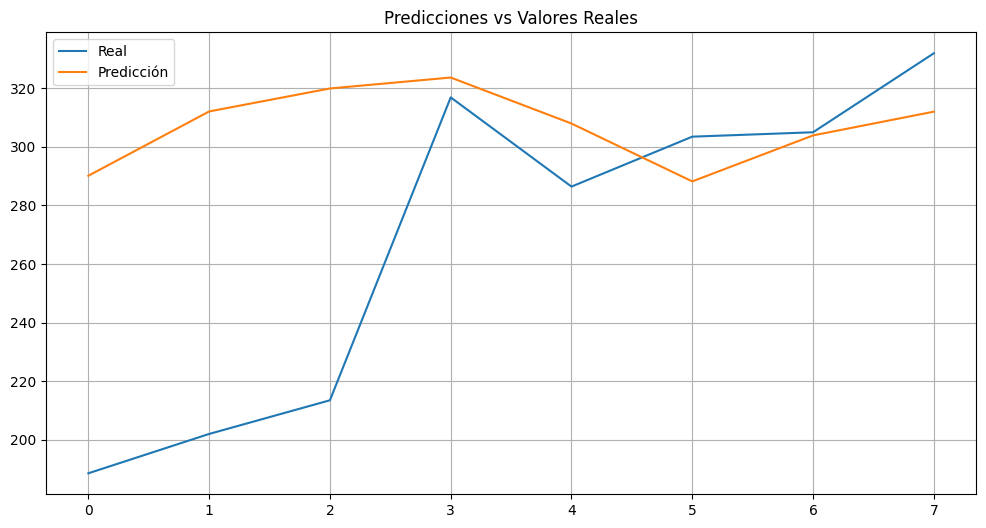

[I 2025-04-05 08:37:59,012] A new study created in memory with name: no-name-42d80d0e-99e1-453b-ae63-a3d17b5e492d



MODELO: CNN_LSTM

Optimizando hiperparámetros...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[I 2025-04-05 08:38:09,533] Trial 0 finished with value: 0.015253697521984577 and parameters: {'learning_rate': 0.0003415923135937774, 'batch_size': 32, 'cnn_filters': 46, 'lstm_units': 123}. Best is trial 0 with value: 0.015253697521984577.
[I 2025-04-05 08:38:21,330] Trial 1 finished with value: 0.012812472879886627 and parameters: {'learning_rate': 0.0009113823634622063, 'batch_size': 16, 'cnn_filters': 71, 'lstm_units': 76}. Best is trial 1 with value: 0.012812472879886627.
[I 2025-04-05 08:38:28,757] Trial 2 finished with value: 0.016894299536943436 and parameters: {'learning_rate': 0.004931725807055634, 'batch_size': 32, 'cnn_filters': 85, 'lstm_units': 118}. Best is trial 1 with value: 0.012812472879886627.
[I 2025-04-05 08:38:52,937] Trial 3 finished with value: 0.043373074382543564 and parameters: {'learning_rate': 1.4960285175334962e-05, 'batch_size': 32, 'cnn_filters': 72, 'lstm_units': 108}. Best is trial 1 with value: 0.012812472879886627.
[I 2025-04-05 08:39:15,208] Trial

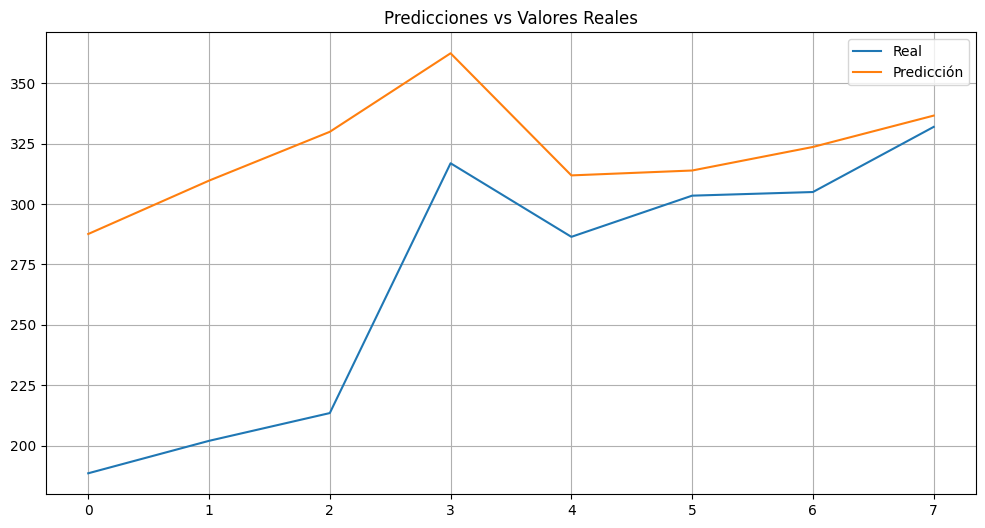


Mejor modelo: MLP
Métricas:
mse: 2343.5358
mae: 40.2078
mape: 0.1776
r2: 0.1868


In [21]:
# Ejecutar el experimento completo
results = forecaster.run_experiment(n_steps=7, n_trials=30)

# Obtener el mejor modelo
best_model = forecaster.get_best_model()

### Conclusión Final:

En este análisis de los modelos utilizados para la predicción de órdenes, se compararon diferentes enfoques, incluyendo redes neuronales de tipo MLP, CNN, LSTM y una combinación de CNN-LSTM. Tras evaluar las métricas clave como RMSE, MAE, MAPE y R², se obtuvieron los siguientes resultados:

1. **Mejor rendimiento global**: El modelo **CNN-V1** mostró el mejor desempeño en la mayoría de las métricas. Logró un RMSE bajo (43.01), MAE bajo (38.11) y el MAPE más bajo (0.16%), lo que indica que es el modelo más preciso en términos de error absoluto y relativo. Además, su valor de R² (0.3581) es el más alto entre los modelos, lo que indica que puede explicar una mayor parte de la variabilidad de los datos en comparación con otros modelos.

2. **Modelos de peor rendimiento**: Los modelos **MLP-V3** y **LSTM-V3** presentaron un rendimiento deficiente, con valores negativos en R² (-0.9247 y -5.6165, respectivamente), lo que indica que sus predicciones son peores que simplemente utilizar la media de los datos. Estos modelos también mostraron valores elevados en RMSE, lo que sugiere que no son adecuados para el problema en cuestión sin ajustes significativos.

3. **Modelos híbridos (CNN-LSTM)**: Los modelos **CNN-LSTM** mostraron un rendimiento intermedio. Aunque no alcanzaron el nivel de los modelos CNN, su desempeño fue mejor que el de los modelos MLP y LSTM. Esto sugiere que combinar redes neuronales convolucionales y LSTM podría ser útil si se busca capturar tanto patrones espaciales como secuenciales, aunque aún tienen margen de mejora.

### Recomendaciones:
- **Modelo óptimo**: Basado en los resultados, el modelo **CNN-V1** es el más adecuado para este tipo de predicción, destacándose por su bajo error en las métricas de desempeño. Sin embargo, es recomendable realizar ajustes adicionales en los hiperparámetros y experimentar con técnicas de regularización para mejorar aún más la capacidad de generalización del modelo.
- **Modelos a reconsiderar**: Los modelos **MLP-V3** y **LSTM-V3** deberían ser descartados o reajustados significativamente debido a su bajo rendimiento y la incapacidad de modelar adecuadamente los datos en este contexto.

### Optimización de Hiperparámetros:
Para mejorar aún más el rendimiento de los modelos seleccionados, se recomienda el uso de herramientas avanzadas de optimización de hiperparámetros como **Optuna**. Optuna es una herramienta de optimización eficiente y flexible que permite ajustar los hiperparámetros de los modelos de manera automática utilizando algoritmos avanzados como el Estimador Parzen Estructurado (TPE) y estrategias de poda. Con su capacidad para gestionar grandes espacios de búsqueda y su integración con frameworks populares como PyTorch y TensorFlow, Optuna puede ayudar a mejorar significativamente el rendimiento de los modelos y hacer un uso más eficiente de los recursos computacionales.


Con el modelo adecuado y una optimización de hiperparámetros eficaz, es posible mejorar el rendimiento de las predicciones y obtener mejores resultados en tareas de pronóstico de órdenes.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>